In [1]:
from src.ppo import *
from src.heist import create_venv
from src.bilinear_impala_simplified import BimpalaCNN
from src.heist import load_model
from src.helpers import ModelActivations
from src.probing import *
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, mean_squared_error, confusion_matrix

In [2]:
def replace_dots_with_underscores(module_names):
    return [name.replace('.', '_') for name in module_names]
def add_activations_to_dataset(dataset, modelactivations, layers, batch_size=32):
    dataset_with_activations = []
    num_batches = (len(dataset) + batch_size - 1) // batch_size
    
    for i in tqdm(range(num_batches), desc="Computing activations in batches"):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, len(dataset))
        batch = dataset[start_idx:end_idx]
        
        # Prepare batch of observations
        observations = [data_point['observation'][0] for data_point in batch]
        observations_array = np.array(observations)
        
        # Ensure the input has 4 dimensions: [batch, height, width, channels]
        if observations_array.ndim == 3:
            observations_array = np.expand_dims(observations_array, axis=0)
        
        # Convert to PyTorch tensor and move to the appropriate device
        observations_tensor = torch.tensor(observations_array, dtype=torch.float32)
        
        
        # Compute activations for the batch
        with torch.no_grad():
            _, activations = modelactivations.run_with_cache(observations_tensor, layers)
        
        # Add activations to each data point in the batch
        for j, data_point in enumerate(batch):
            new_data_point = data_point.copy()
            new_data_point['activations'] = {}
            for layer in layers:
                if layer.replace('.', '_') in activations:
                    new_data_point['activations'][layer.replace('.', '_')]=  activations[layer.replace('.', '_')][j].cpu().numpy()
            dataset_with_activations.append(new_data_point)
    
    return dataset_with_activations

In [3]:
model_path = "/mnt/ssd-1/mechinterp/narmeen/bilinear_experiments_official/bilinear_experiments/bilinear_models/bimpala_maze_simplified.pt"
model =load_model(model_path,7)
print(model)
for k in model.state_dict():
    print(k)
state_dict = model.state_dict()

/mnt/ssd-1/mechinterp/narmeen/bilinear_experiments_official/bilinear_experiments/src/heist.py:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model

Model loaded from /mnt/ssd-1/mechinterp/narmeen/bilinear_experiments_official/bilinear_experiments/bilinear_models/bimpala_maze_simplified.pt
BimpalaCNN(
  (conv): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (conv_seqs): ModuleList(
    (0-2): 3 x ConvSequence(
      (max_pool2d): MaxPool2d(kernel_size=7, stride=2, padding=3, dilation=1, ceil_mode=False)
      (res_block0): ResidualBlock(
        (conv0): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
        (conv1): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
      )
      (res_block1): ResidualBlock(
        (conv0): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
        (conv1): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
      )
    )
  )
  (hidden_fc1): Linear(in_features=2048, out_features=256, bias=False)
  (hidden_fc2): Linear(in_features=2048, out_features=256, bias=False)
  

In [15]:
env = create_venv()
agent = PPO(model, device="cuda" if torch.cuda.is_available() else "cpu")    
dataset = agent.create_dataset_with_labels(env, num_episodes=500, max_steps_per_episode=10000)
#os.makedirs("datasets", exist_ok=True)
#torch.save(dataset, "datasets/probing_dataset.pt")

Generating dataset: 100%|██████████| 500/500 [01:25<00:00,  5.85it/s]


In [17]:
dataset = torch.load("datasets/probing_dataset.pt")
modelactivations = ModelActivations(model)
paths = [name for name, _ in model.named_modules() if name]
print(paths)
complete_dataset = add_activations_to_dataset(dataset[:20000], modelactivations, paths, batch_size=32)

/tmp/ipykernel_1416042/3121775637.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataset = torch.load("datasets/probing_dataset.pt")


['conv', 'conv_seqs', 'conv_seqs.0', 'conv_seqs.0.max_pool2d', 'conv_seqs.0.res_block0', 'conv_seqs.0.res_block0.conv0', 'conv_seqs.0.res_block0.conv1', 'conv_seqs.0.res_block1', 'conv_seqs.0.res_block1.conv0', 'conv_seqs.0.res_block1.conv1', 'conv_seqs.1', 'conv_seqs.1.max_pool2d', 'conv_seqs.1.res_block0', 'conv_seqs.1.res_block0.conv0', 'conv_seqs.1.res_block0.conv1', 'conv_seqs.1.res_block1', 'conv_seqs.1.res_block1.conv0', 'conv_seqs.1.res_block1.conv1', 'conv_seqs.2', 'conv_seqs.2.max_pool2d', 'conv_seqs.2.res_block0', 'conv_seqs.2.res_block0.conv0', 'conv_seqs.2.res_block0.conv1', 'conv_seqs.2.res_block1', 'conv_seqs.2.res_block1.conv0', 'conv_seqs.2.res_block1.conv1', 'hidden_fc1', 'hidden_fc2', 'logits_fc', 'value_fc']


Computing activations in batches: 100%|██████████| 625/625 [00:46<00:00, 13.33it/s]


In [18]:
print(len(complete_dataset))
complete_dataset[0]


20000


{'observation': array([[[[201, 152, 105],
          [201, 152, 105],
          [189, 137,  88],
          ...,
          [199, 150, 102],
          [189, 137,  88],
          [189, 137,  88]],
 
         [[201, 152, 105],
          [201, 152, 105],
          [197, 143,  92],
          ...,
          [201, 152, 105],
          [197, 143,  92],
          [197, 143,  92]],
 
         [[201, 152, 105],
          [201, 152, 105],
          [189, 137,  88],
          ...,
          [201, 152, 105],
          [189, 137,  88],
          [189, 137,  88]],
 
         ...,
 
         [[197, 143,  92],
          [197, 143,  92],
          [201, 152, 105],
          ...,
          [197, 143,  92],
          [201, 152, 105],
          [201, 152, 105]],
 
         [[189, 137,  88],
          [189, 137,  88],
          [189, 137,  88],
          ...,
          [189, 137,  88],
          [189, 137,  88],
          [189, 137,  88]],
 
         [[197, 143,  92],
          [197, 143,  92],
          [201,

In [19]:
def train_all_probes(dataset, layers = []):
    probes = {}
    for layer in layers:
        if layer in dataset[0]['activations']:
            input_dim = dataset[0]['activations'][layer].size
            grid_size = int(np.sqrt(len(dataset[0]['labels']['cheese_presence'])))
            n_actions = 5

            neighboring_walls_probe = NeighboringWallsProbe(input_dim, layer=layer)
            n_action_classes = max(max(d['labels']['next_n_actions']) for d in dataset) + 1
            next_n_actions_probe = NextNActionsProbe(input_dim, n_action_classes, n_actions, layer=layer)
            cheese_presence_probe = CheesePresenceProbe(input_dim, grid_size, layer=layer)
            mouse_location_probe = MouseLocationProbe(input_dim, layer=layer)

            print(f"Training probes for layer {layer}")
            print("Training Neighboring Walls Probe...")
            neighboring_walls_probe.train(dataset)
            print("Training Next N Actions Probe...")
            next_n_actions_probe.train(dataset)
            print("Training Cheese Presence Probe...")
            cheese_presence_probe.train(dataset)
            print("Training Mouse Location Probe...")
            mouse_location_probe.train(dataset)

            probes[layer] = {
                'neighboring_walls': neighboring_walls_probe,
                'next_n_actions': next_n_actions_probe,
                'cheese_presence': cheese_presence_probe,
                'mouse_location': mouse_location_probe
            }
    
    return probes

train_data, test_data = train_test_split(complete_dataset, test_size=0.2, random_state=42)
probes = train_all_probes(train_data, replace_dots_with_underscores(paths))


Training probes for layer conv
Training Neighboring Walls Probe...
Epoch 1, Validation Loss: 0.7155355286598205
Epoch 2, Validation Loss: 0.7646215677261352
Epoch 3, Validation Loss: 0.6859735280275345
Epoch 4, Validation Loss: 0.8232979774475098
Epoch 5, Validation Loss: 0.8641324174404145
Epoch 6, Validation Loss: 0.7646831718087196
Epoch 7, Validation Loss: 0.648718997836113
Epoch 8, Validation Loss: 0.8703805142641068
Epoch 9, Validation Loss: 0.798133607506752
Epoch 10, Validation Loss: 0.8562153178453445
Training Next N Actions Probe...
Original dataset size: 16000
Filtered dataset size: 12759
Removed 3241 observations with fewer than 5 actions
Epoch 1, Training Loss: 1.83040939603106, Validation Loss: 1.4950304195284843
Epoch 2, Training Loss: 1.5862135358364977, Validation Loss: 1.5619573041796684
Epoch 3, Training Loss: 1.6317760847205278, Validation Loss: 1.5389864653348924
Epoch 4, Training Loss: 1.6142435036482856, Validation Loss: 1.425415113568306
Epoch 5, Training Loss: 

In [20]:
torch.save(probes, "trained_probes_20000.pt")

/tmp/ipykernel_1416042/4270264803.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  probes = torch.load("trained_probes_20000.pt")


Visualizing results for layer: conv


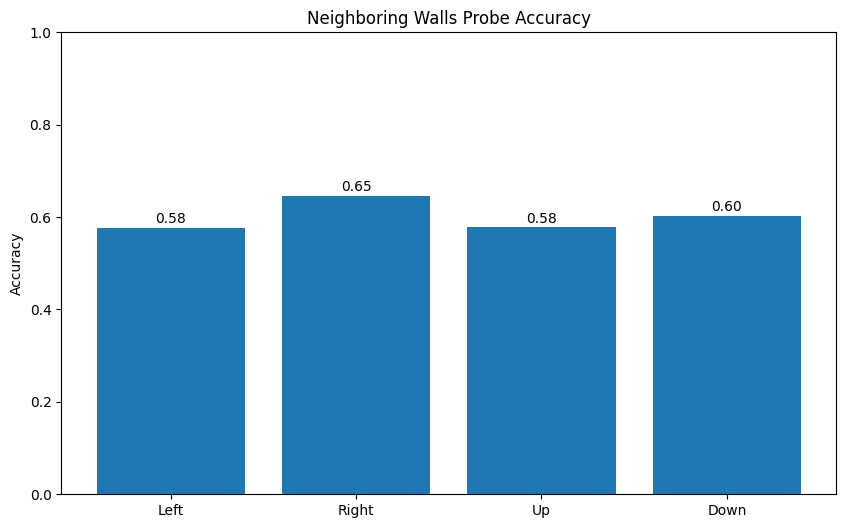

Original dataset size: 4000
Filtered dataset size: 3182
Removed 818 observations with fewer than 5 actions


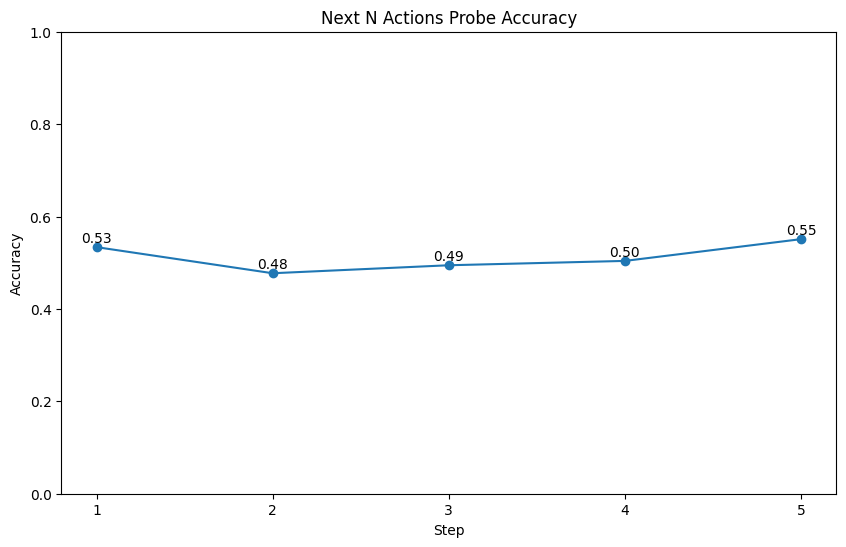

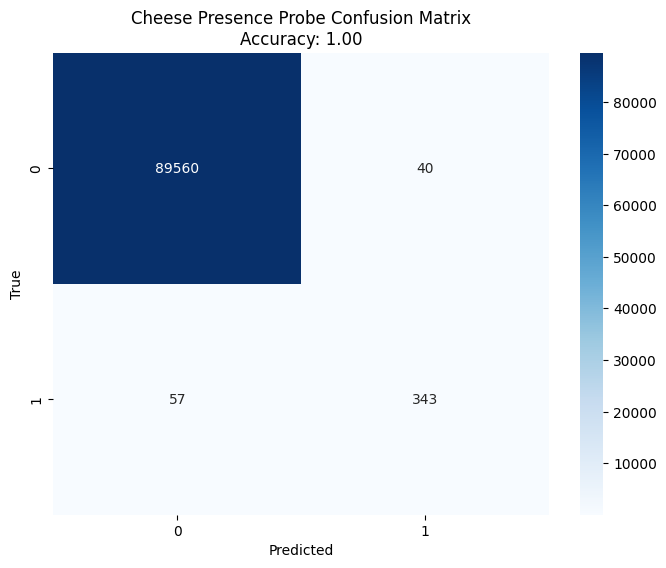

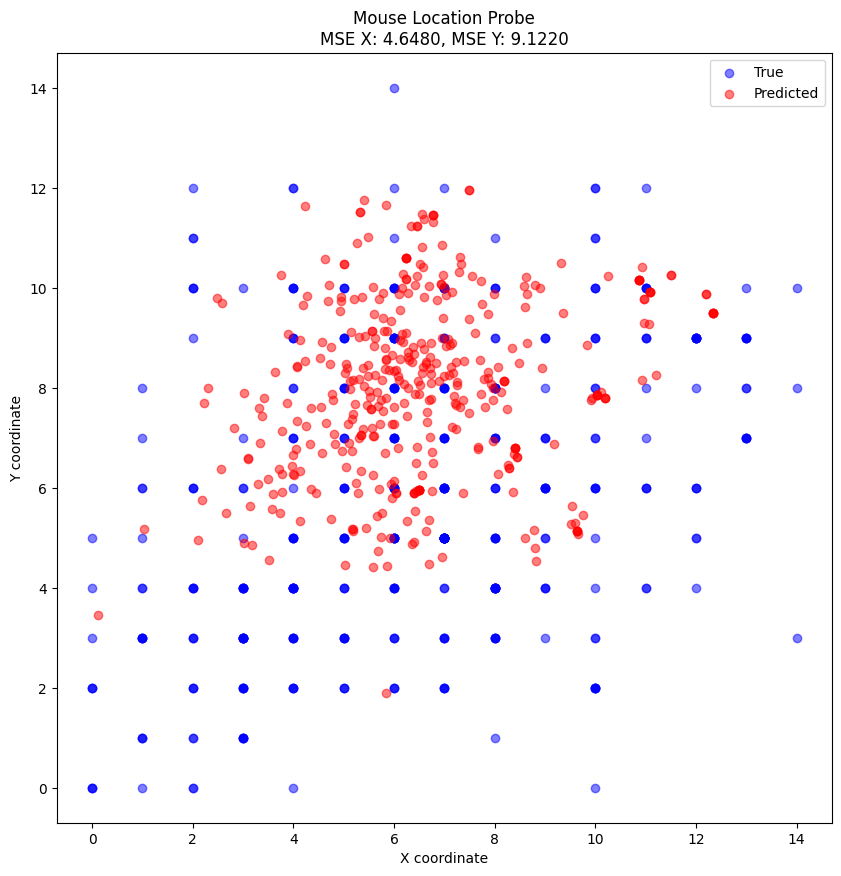

Visualizing results for layer: conv_seqs_0


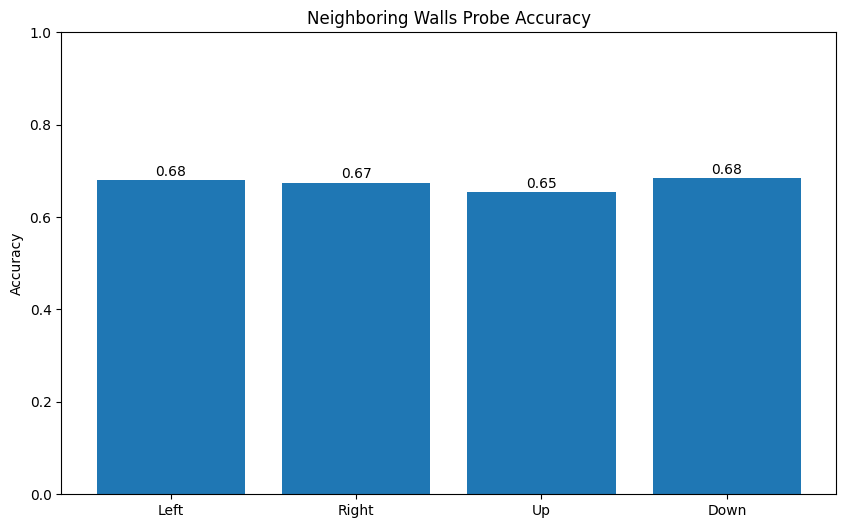

Original dataset size: 4000
Filtered dataset size: 3182
Removed 818 observations with fewer than 5 actions


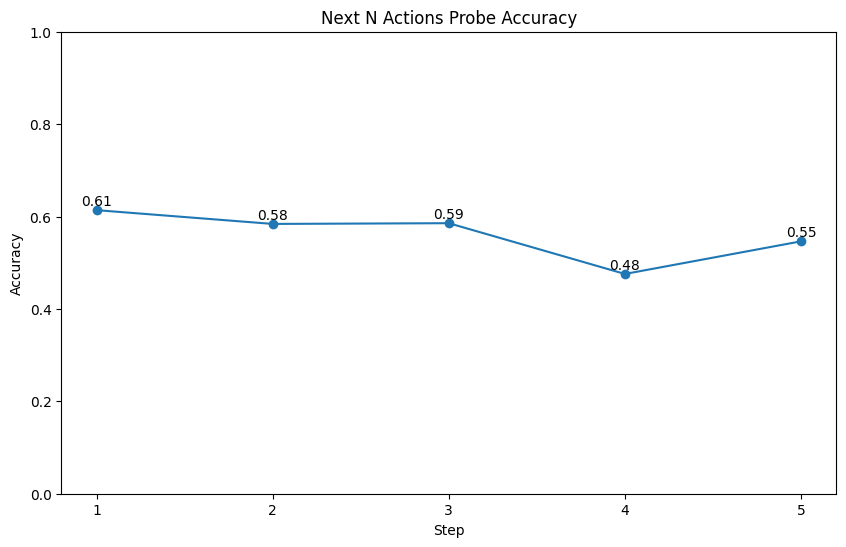

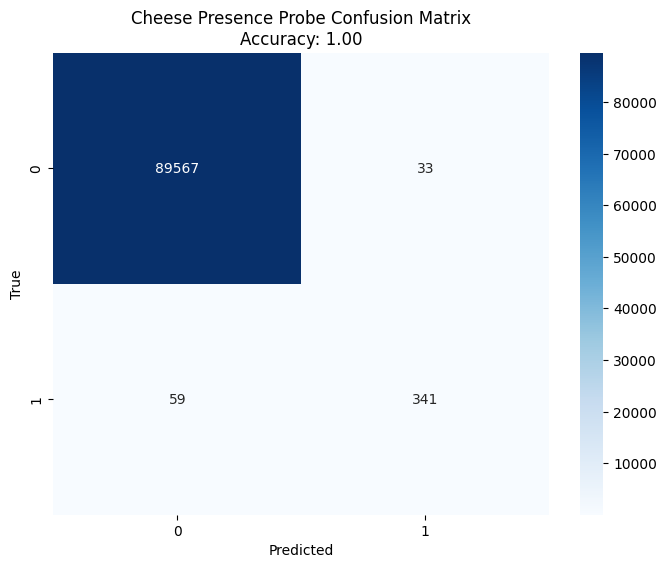

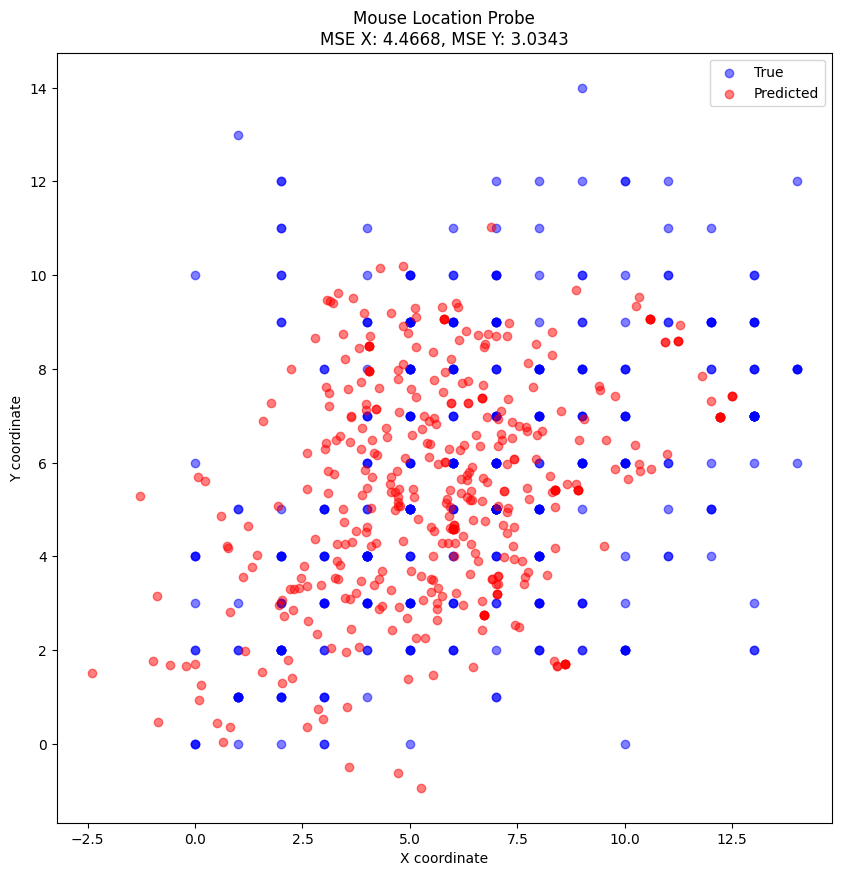

Visualizing results for layer: conv_seqs_0_max_pool2d


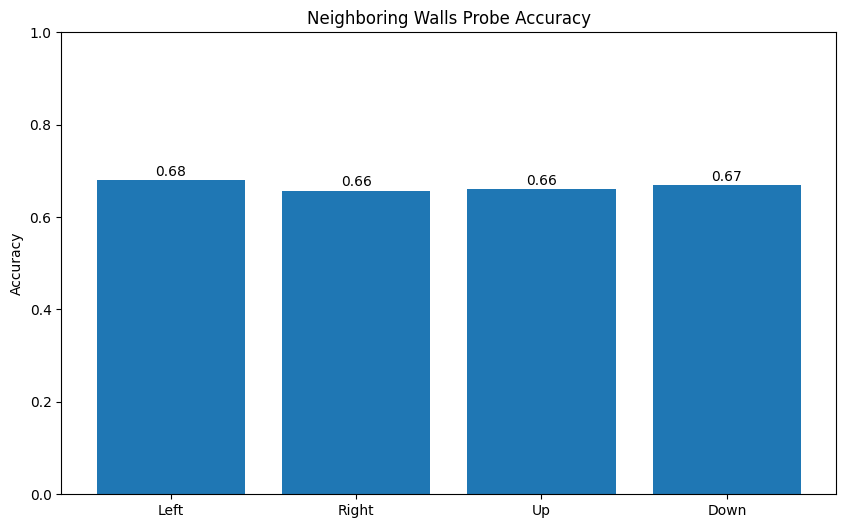

Original dataset size: 4000
Filtered dataset size: 3182
Removed 818 observations with fewer than 5 actions


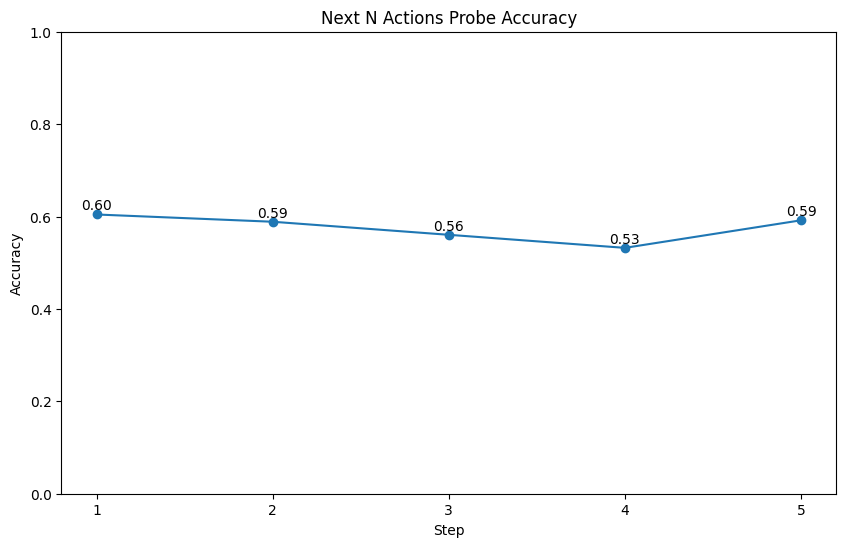

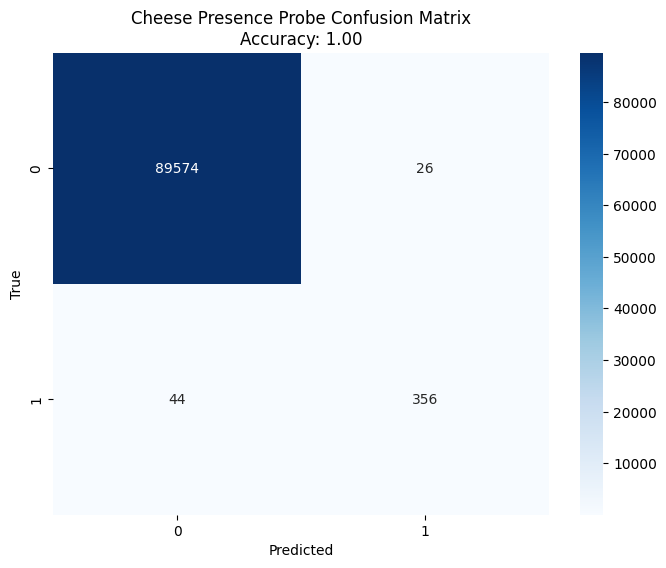

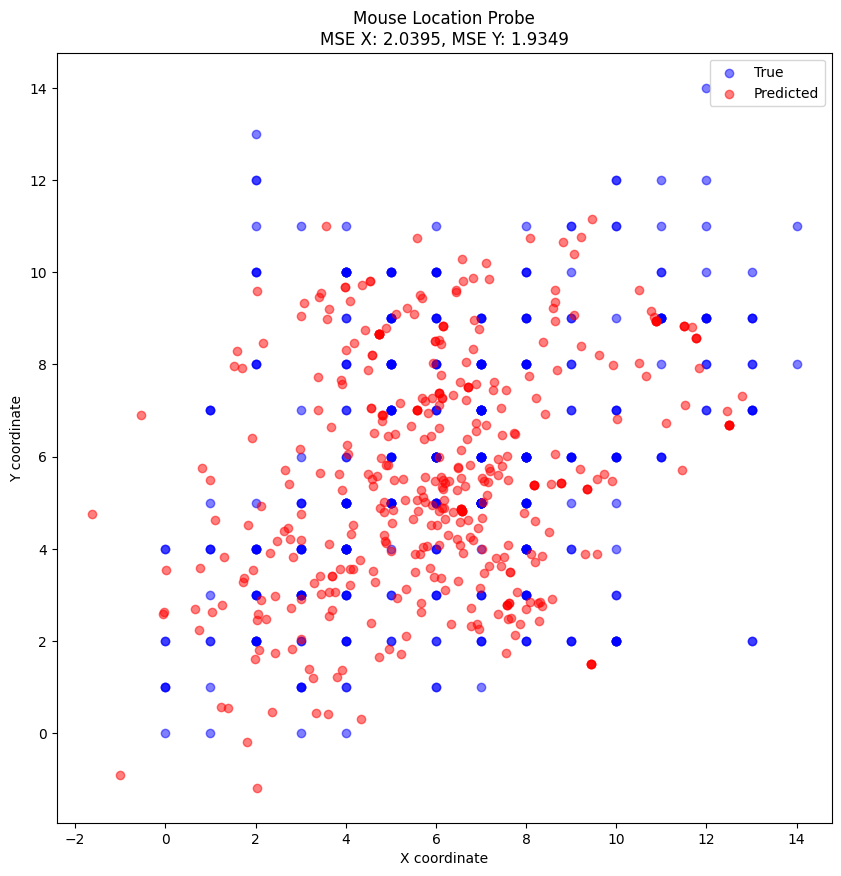

Visualizing results for layer: conv_seqs_0_res_block0


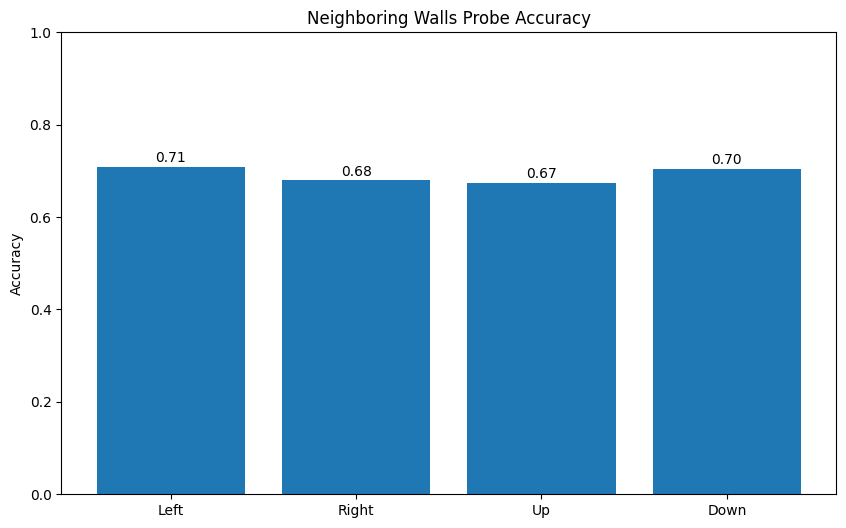

Original dataset size: 4000
Filtered dataset size: 3182
Removed 818 observations with fewer than 5 actions


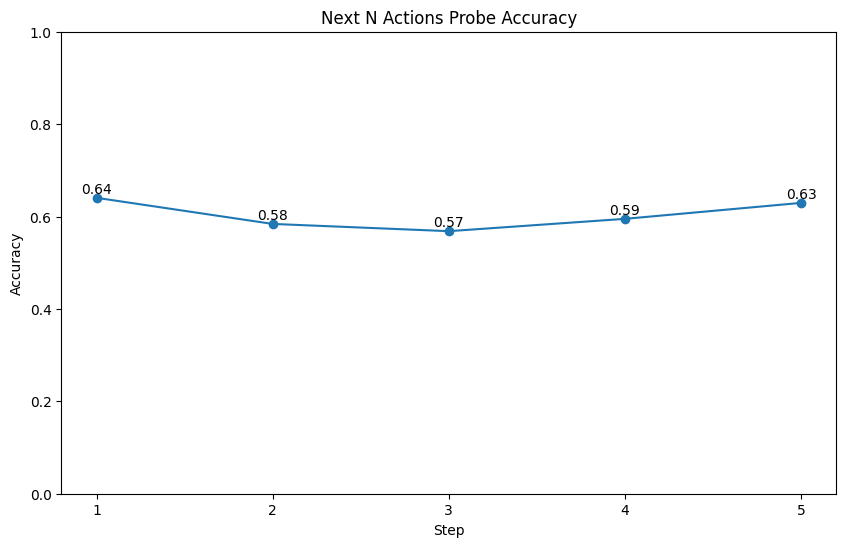

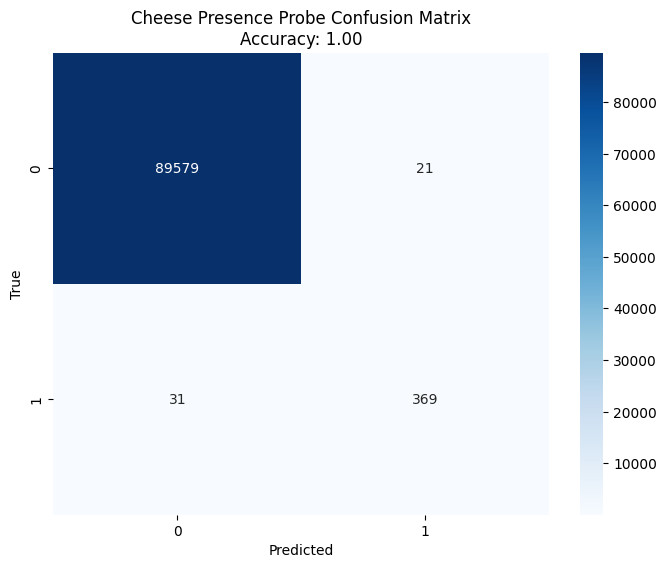

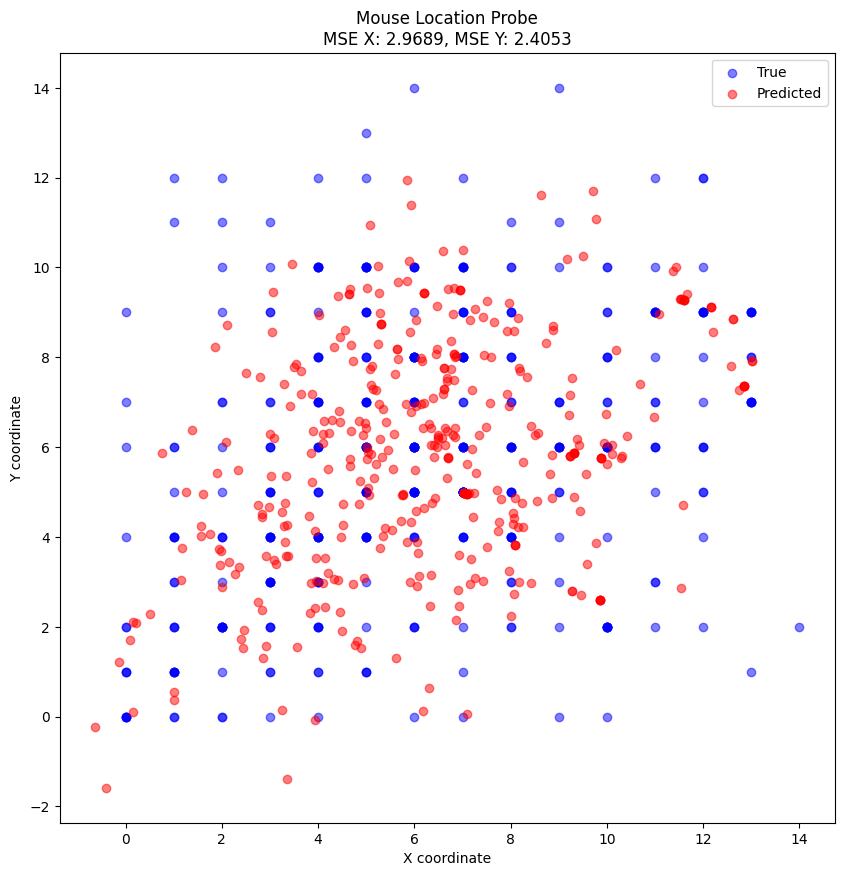

Visualizing results for layer: conv_seqs_0_res_block0_conv0


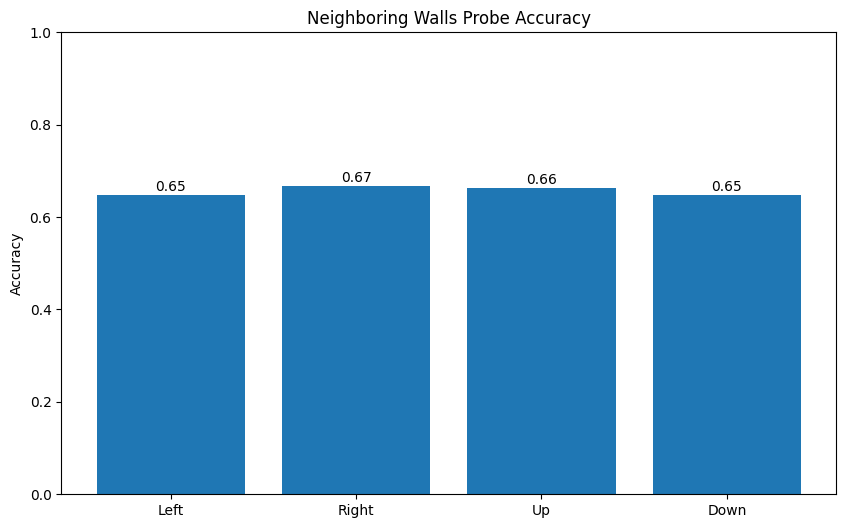

Original dataset size: 4000
Filtered dataset size: 3182
Removed 818 observations with fewer than 5 actions


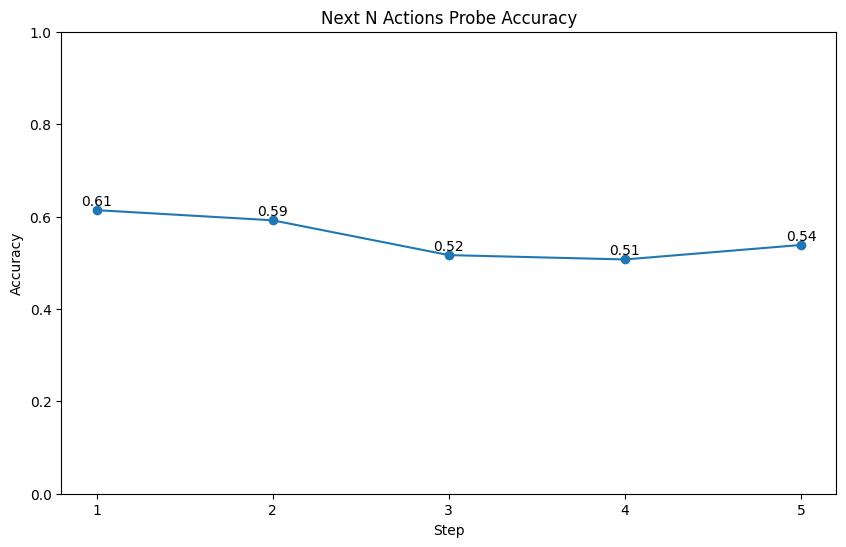

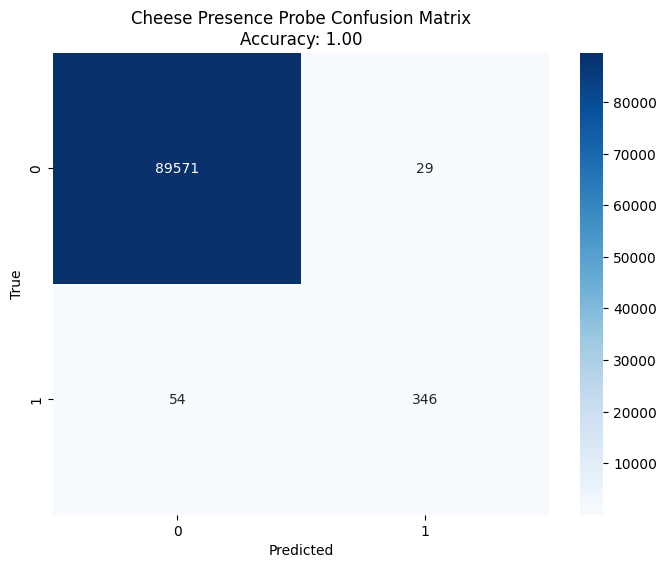

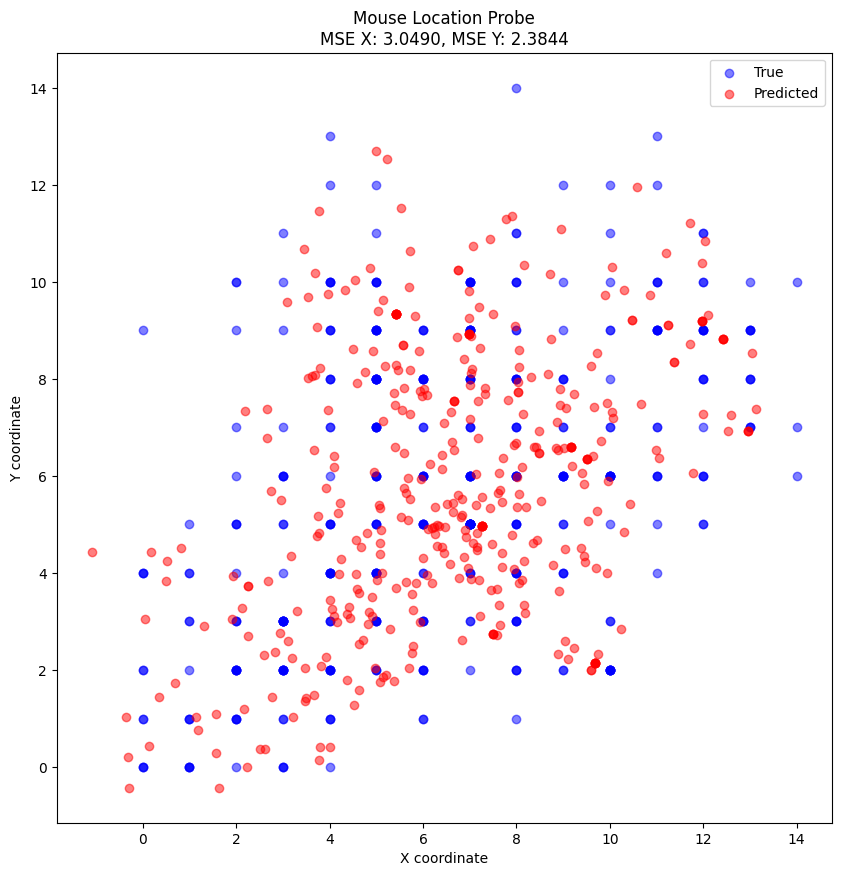

Visualizing results for layer: conv_seqs_0_res_block0_conv1


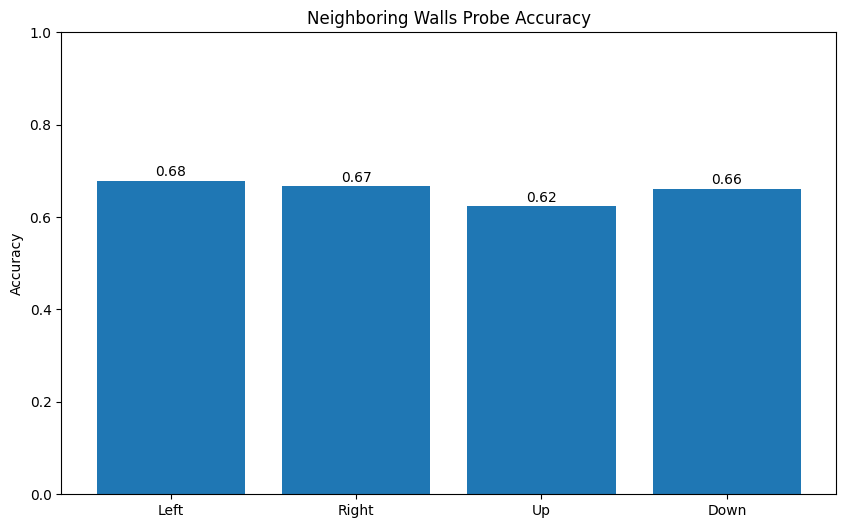

Original dataset size: 4000
Filtered dataset size: 3182
Removed 818 observations with fewer than 5 actions


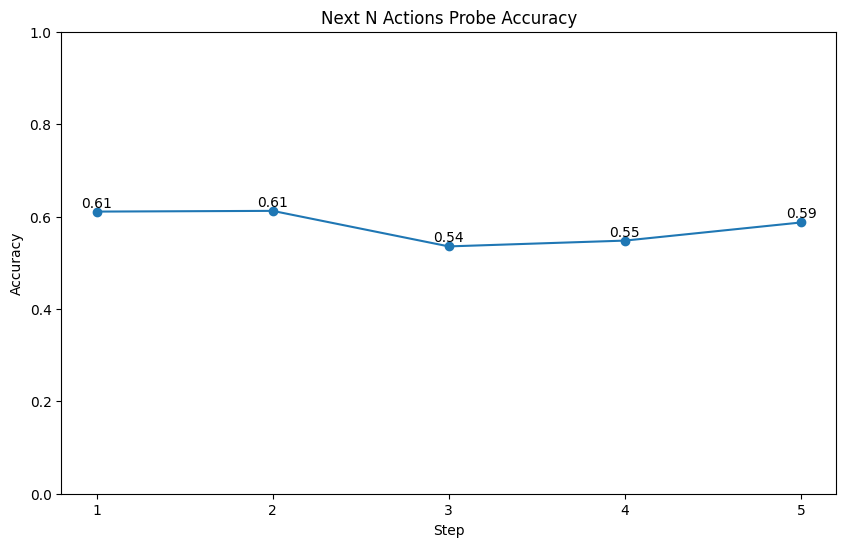

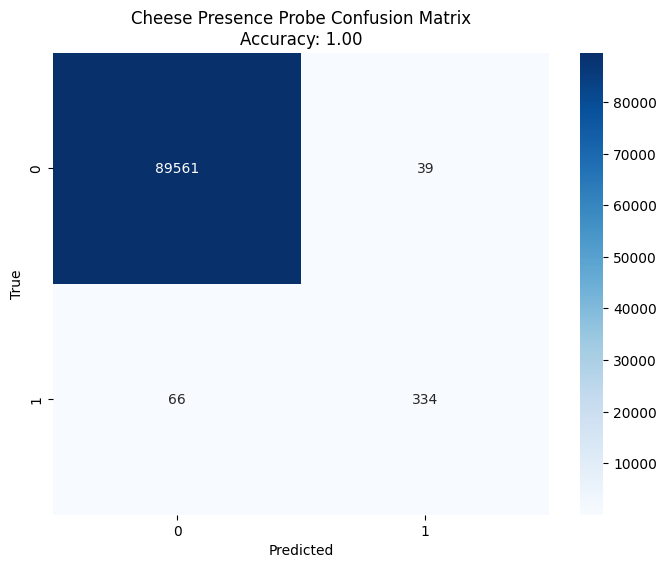

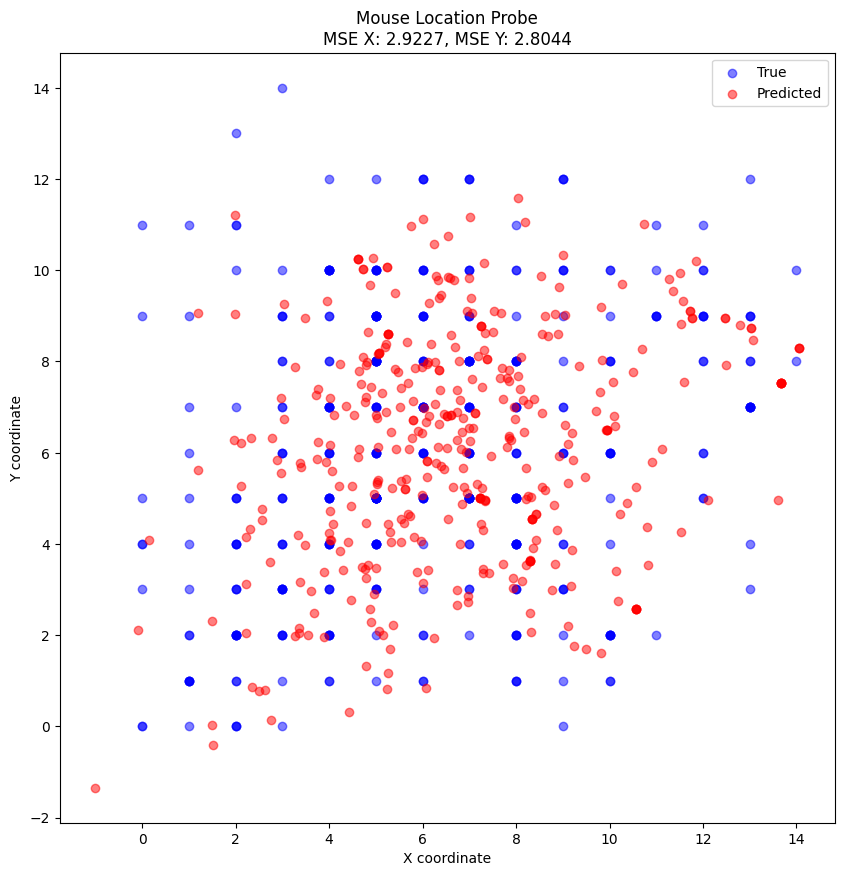

Visualizing results for layer: conv_seqs_0_res_block1


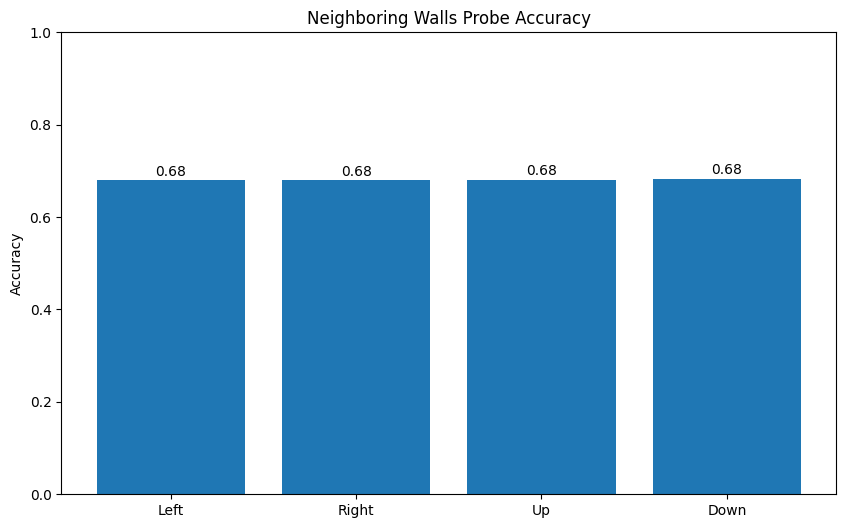

Original dataset size: 4000
Filtered dataset size: 3182
Removed 818 observations with fewer than 5 actions


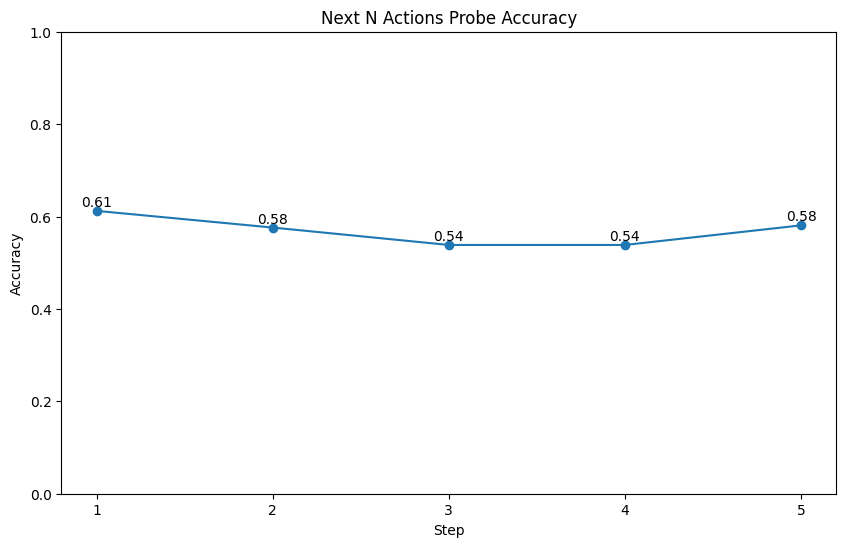

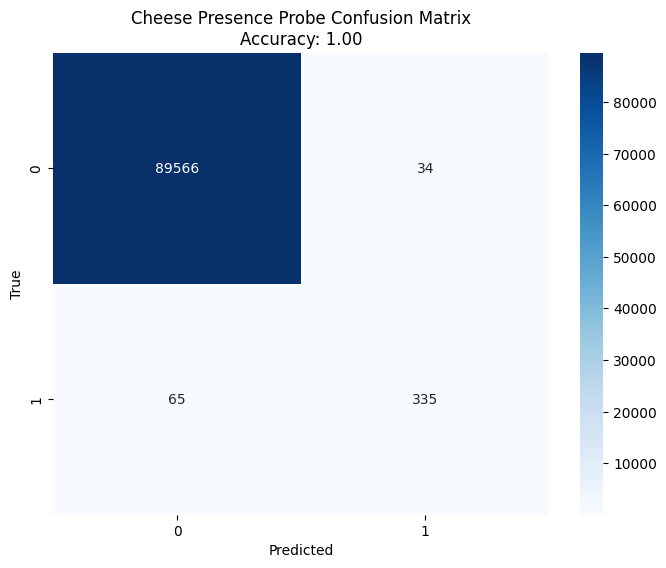

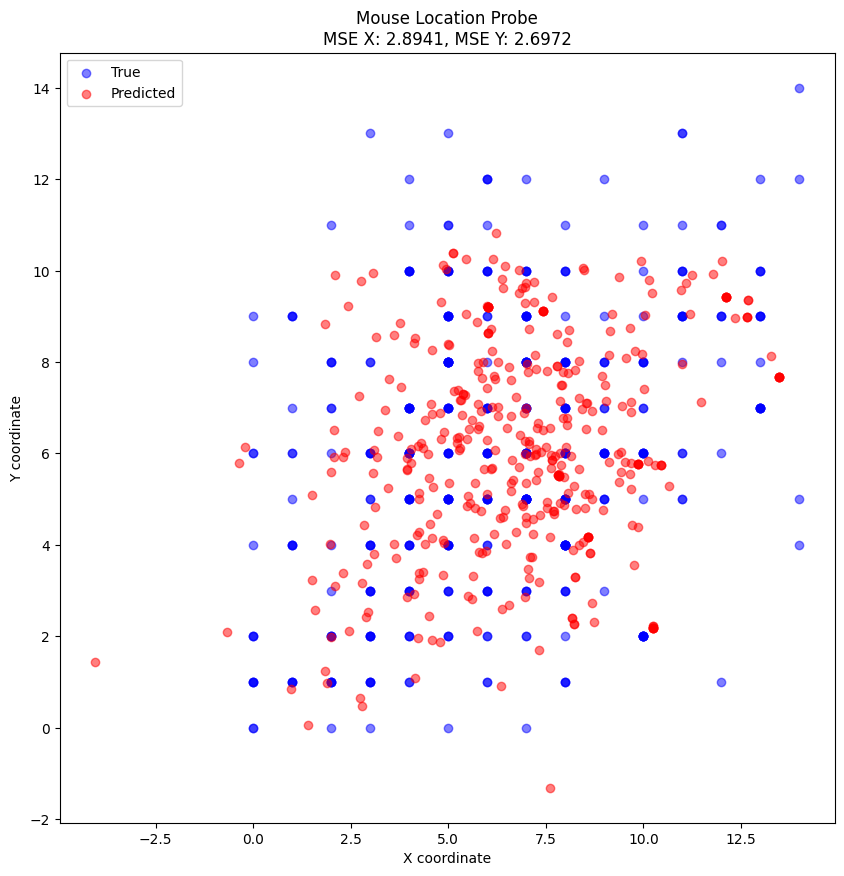

Visualizing results for layer: conv_seqs_0_res_block1_conv0


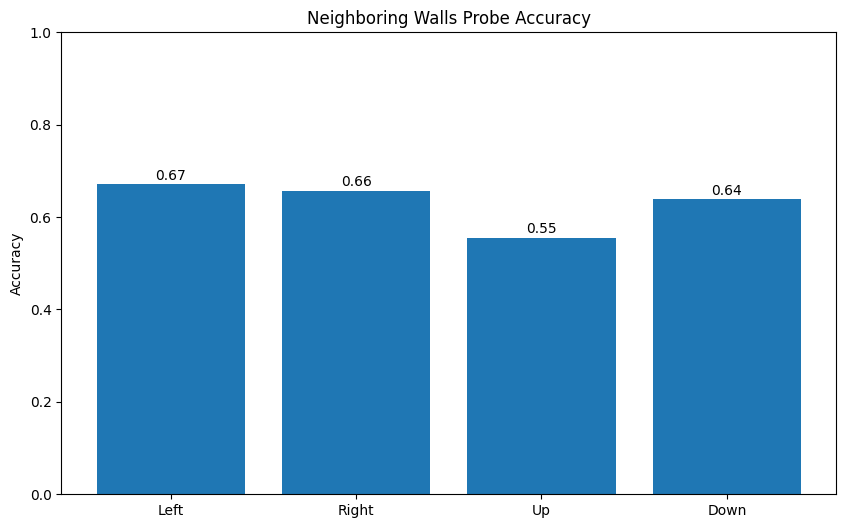

Original dataset size: 4000
Filtered dataset size: 3182
Removed 818 observations with fewer than 5 actions


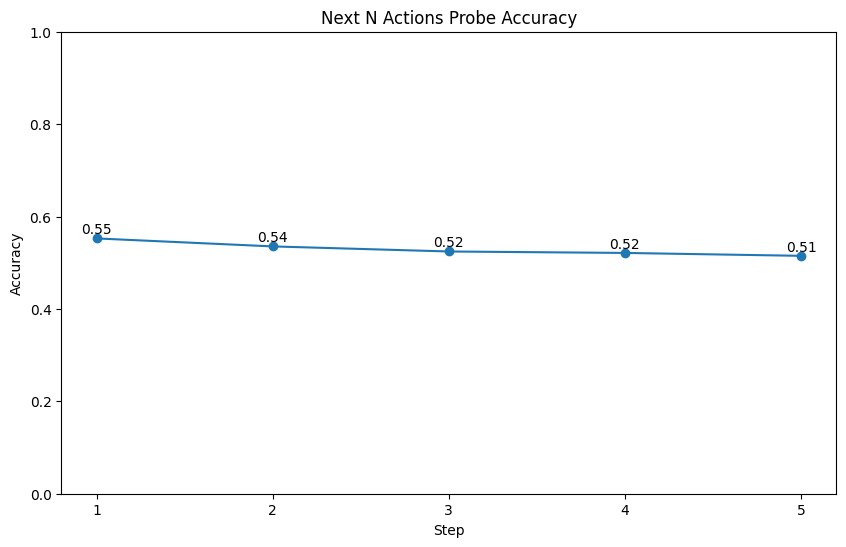

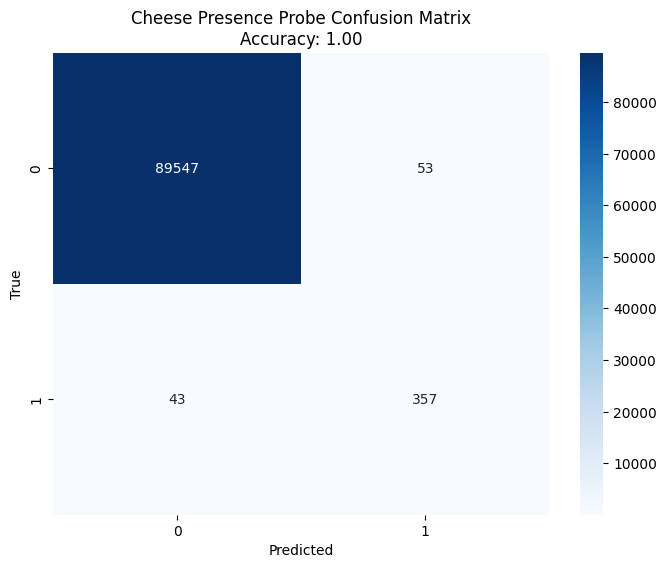

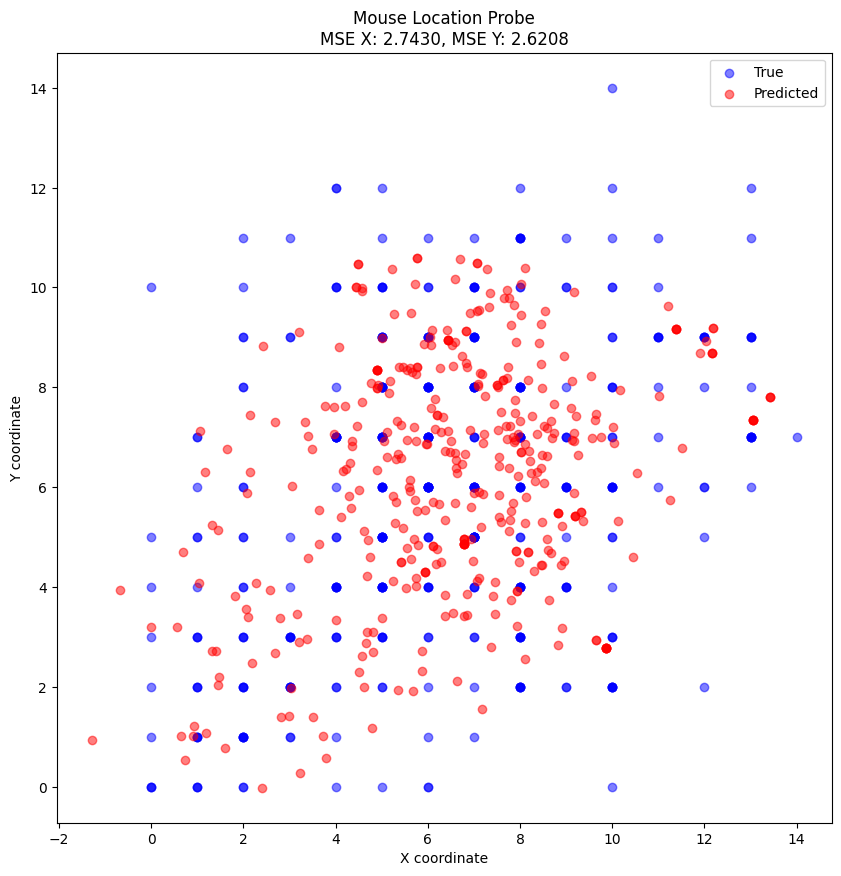

Visualizing results for layer: conv_seqs_0_res_block1_conv1


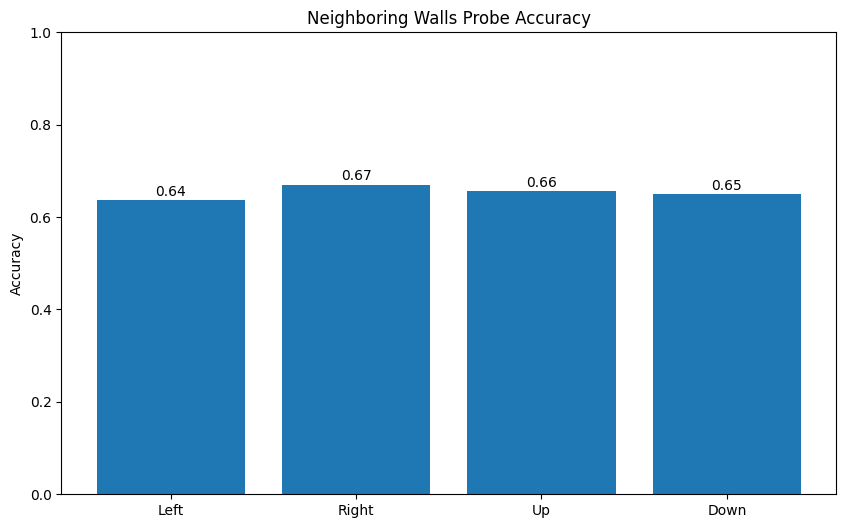

Original dataset size: 4000
Filtered dataset size: 3182
Removed 818 observations with fewer than 5 actions


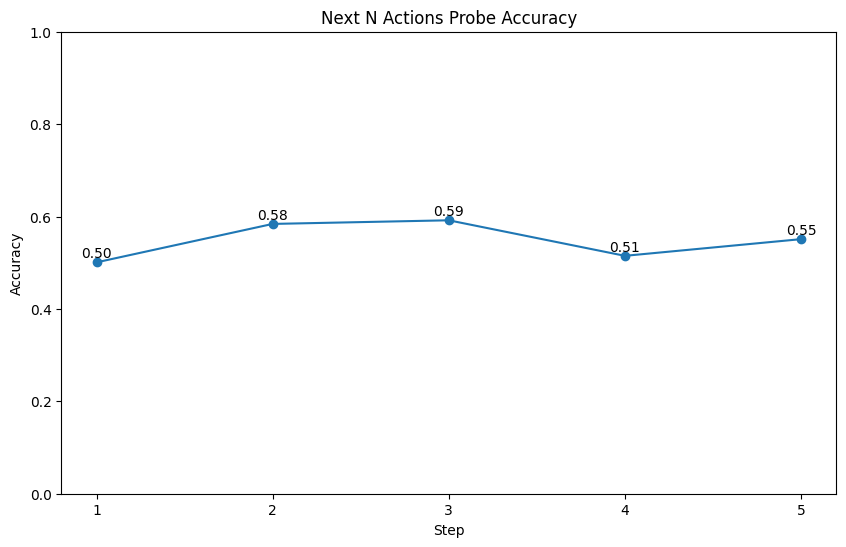

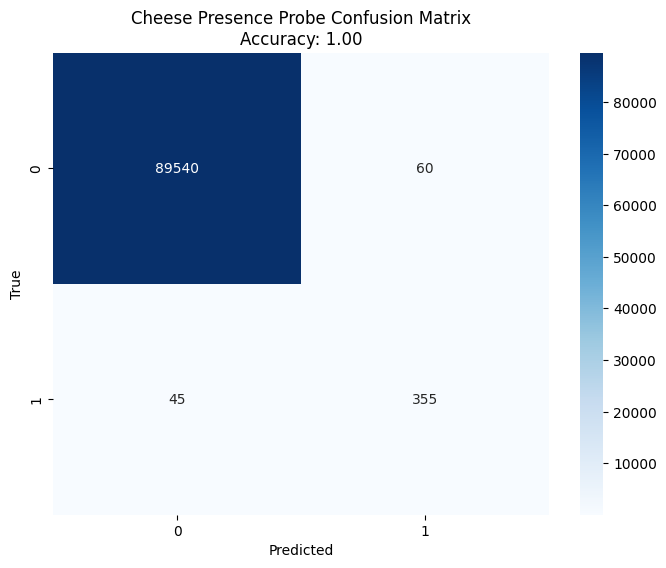

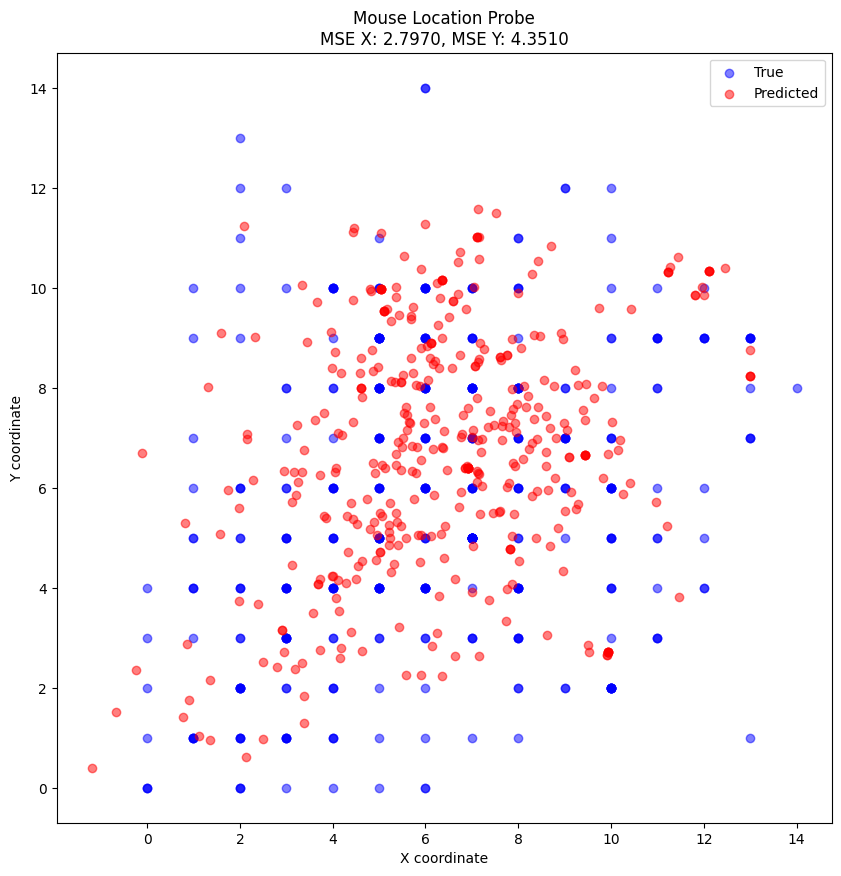

Visualizing results for layer: conv_seqs_1


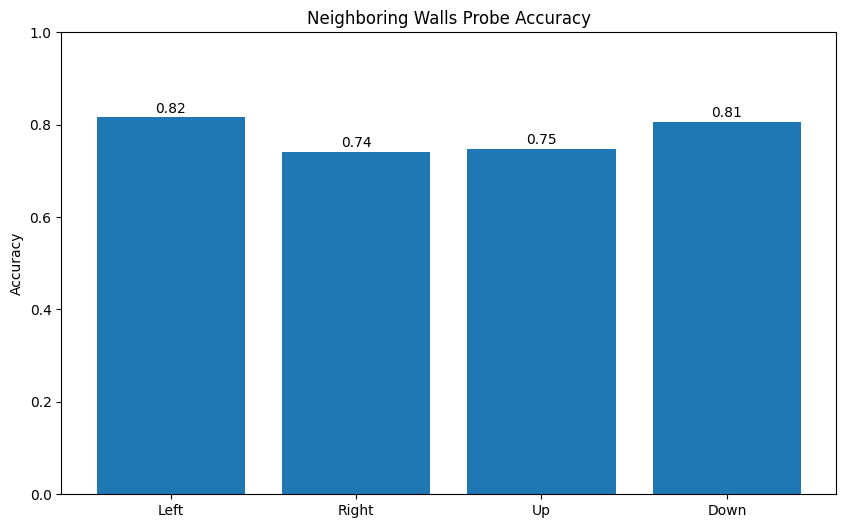

Original dataset size: 4000
Filtered dataset size: 3182
Removed 818 observations with fewer than 5 actions


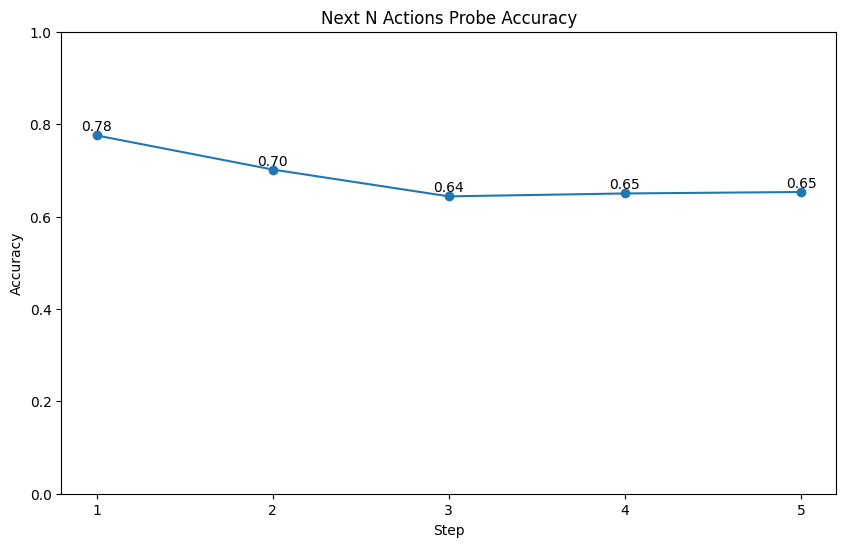

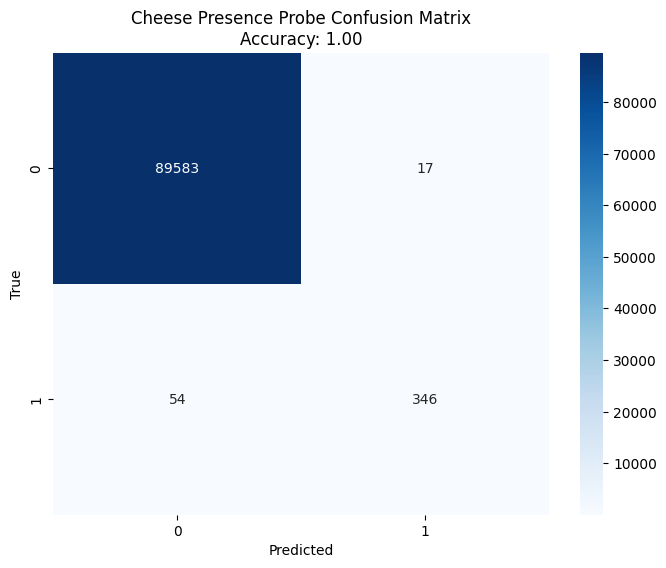

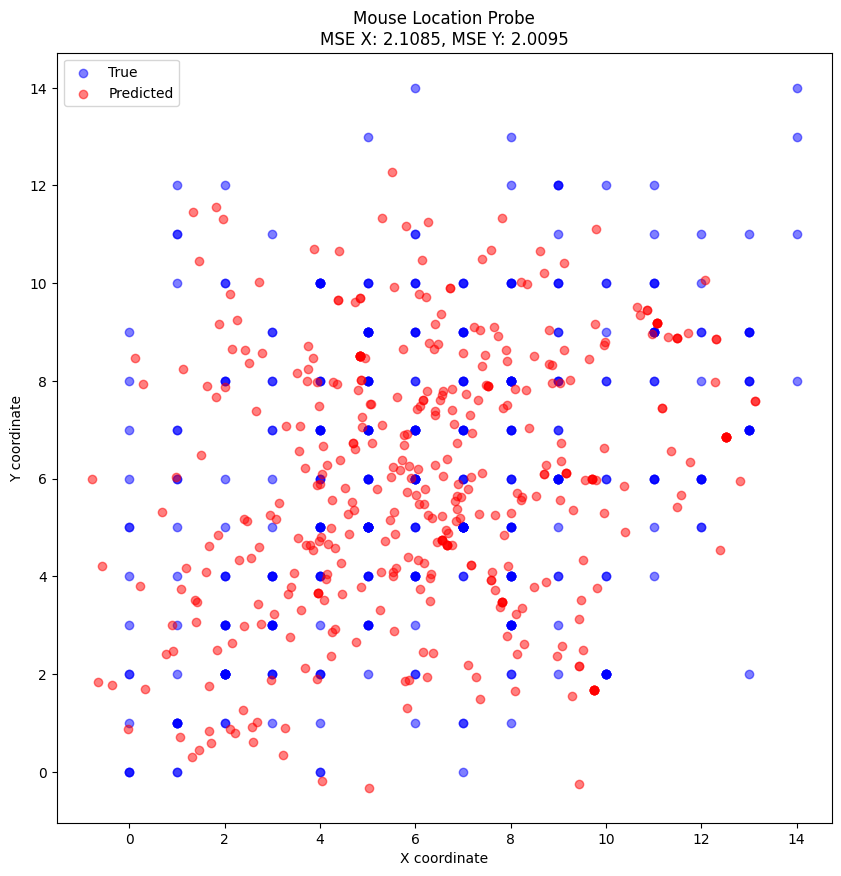

Visualizing results for layer: conv_seqs_1_max_pool2d


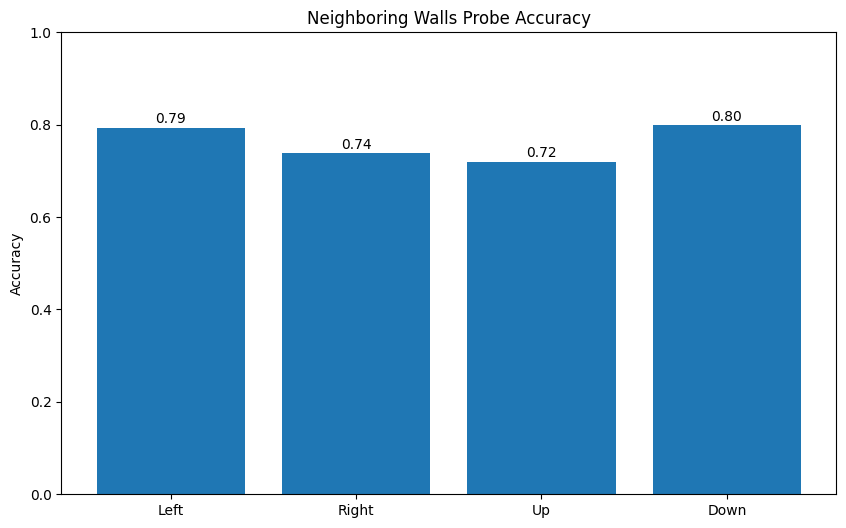

Original dataset size: 4000
Filtered dataset size: 3182
Removed 818 observations with fewer than 5 actions


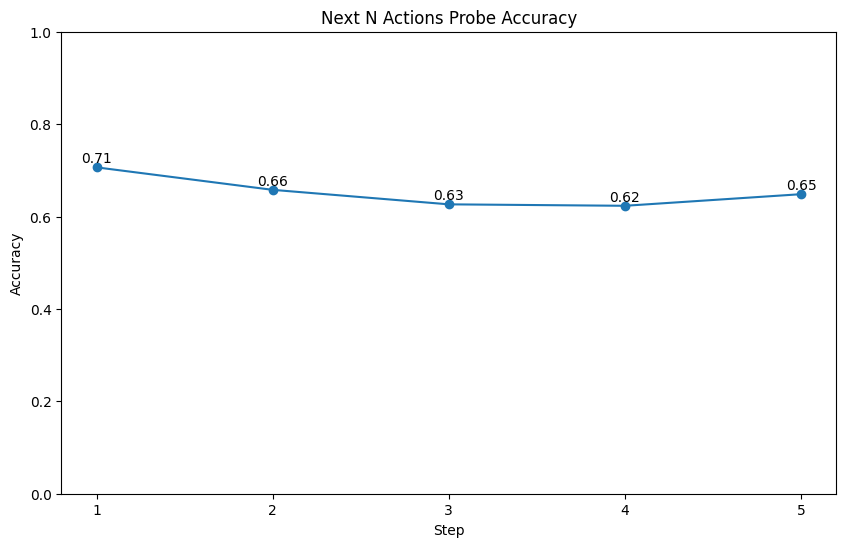

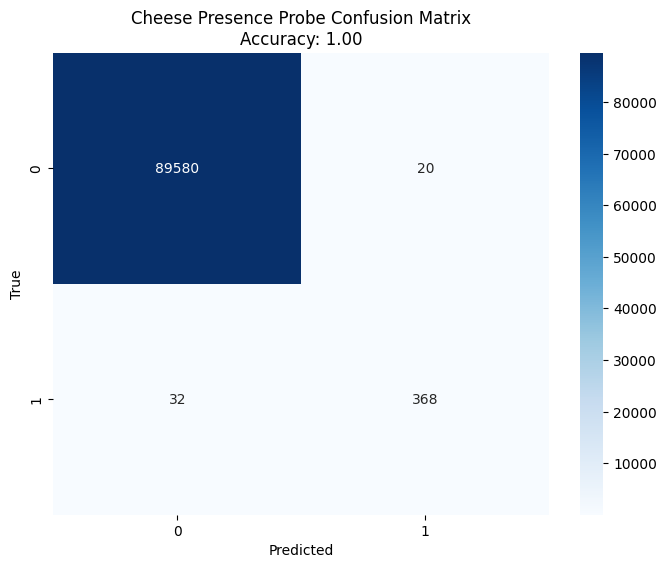

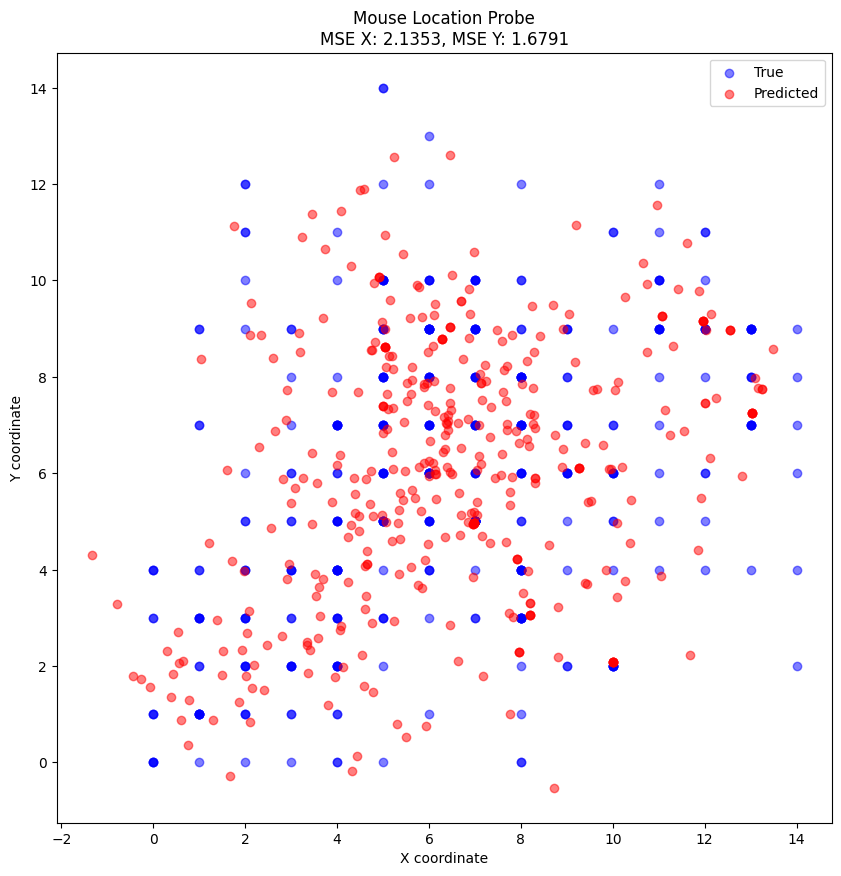

Visualizing results for layer: conv_seqs_1_res_block0


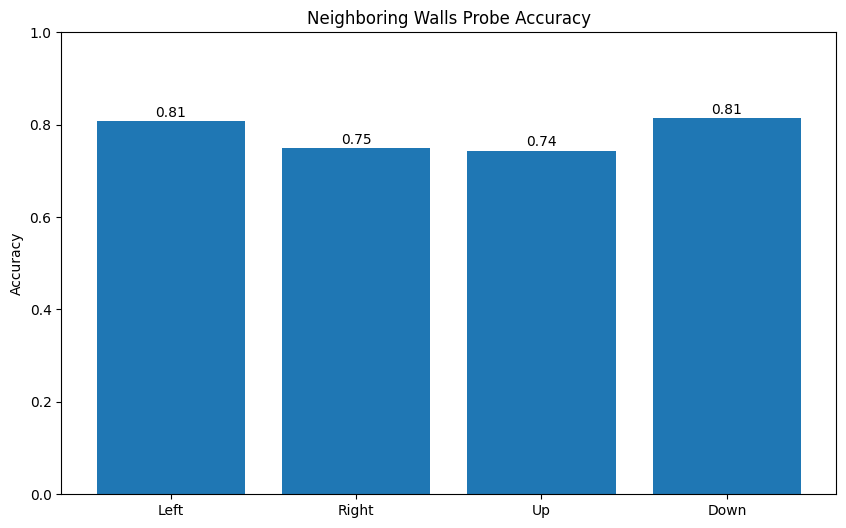

Original dataset size: 4000
Filtered dataset size: 3182
Removed 818 observations with fewer than 5 actions


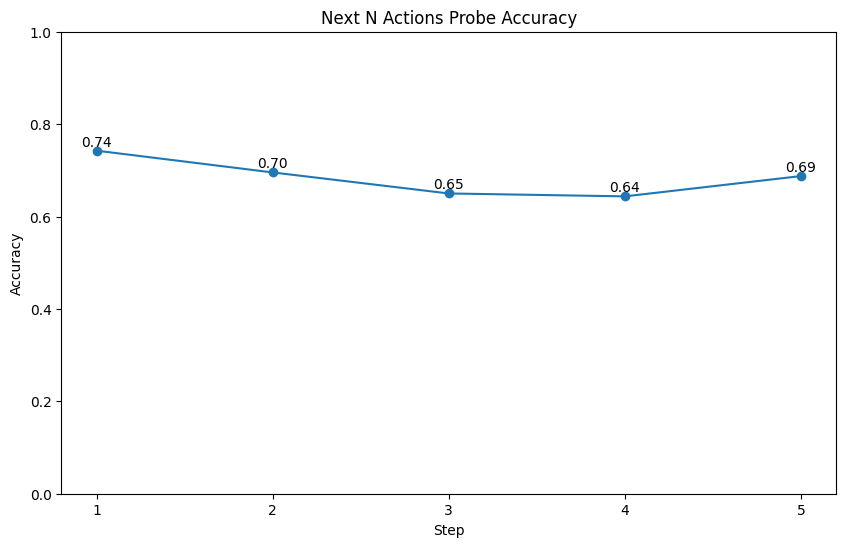

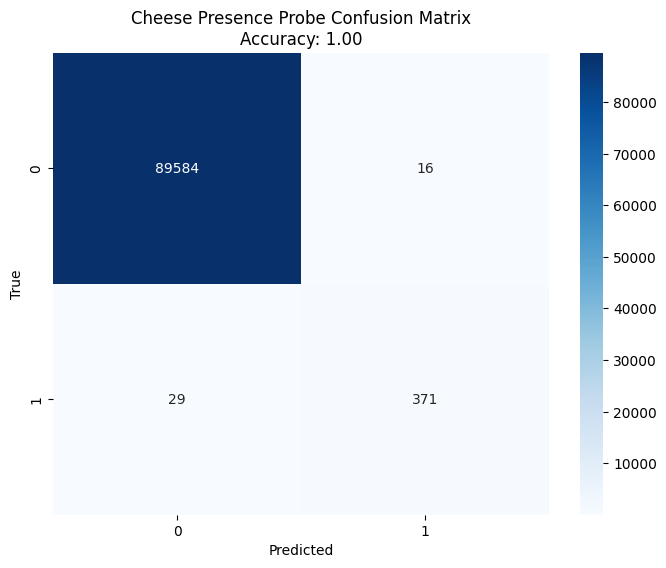

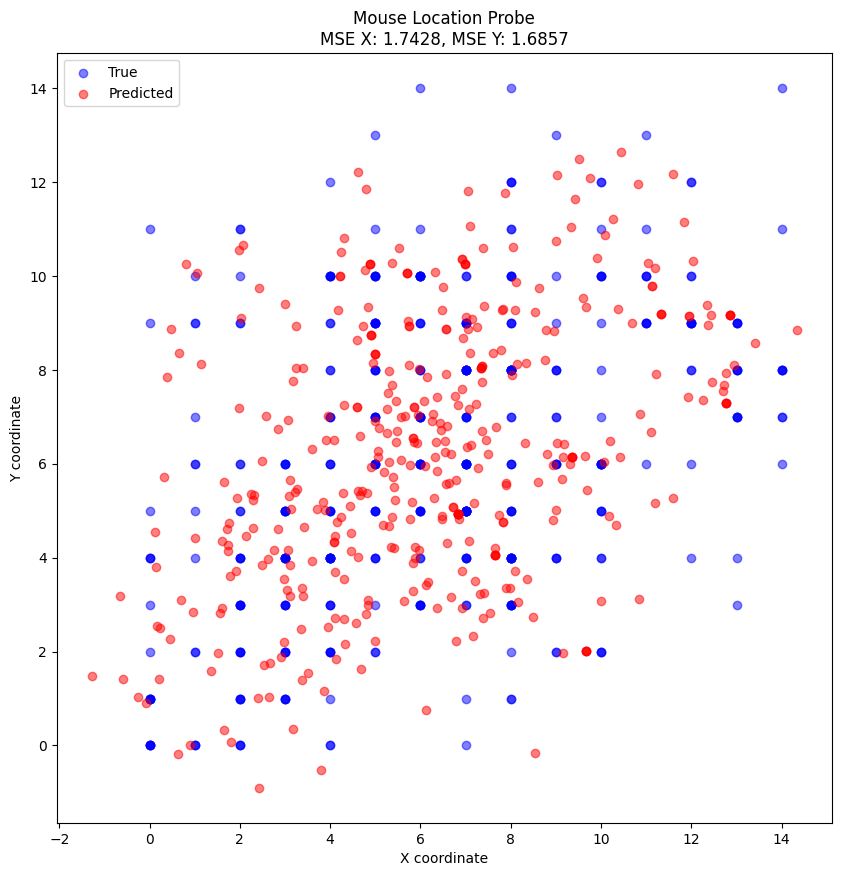

Visualizing results for layer: conv_seqs_1_res_block0_conv0


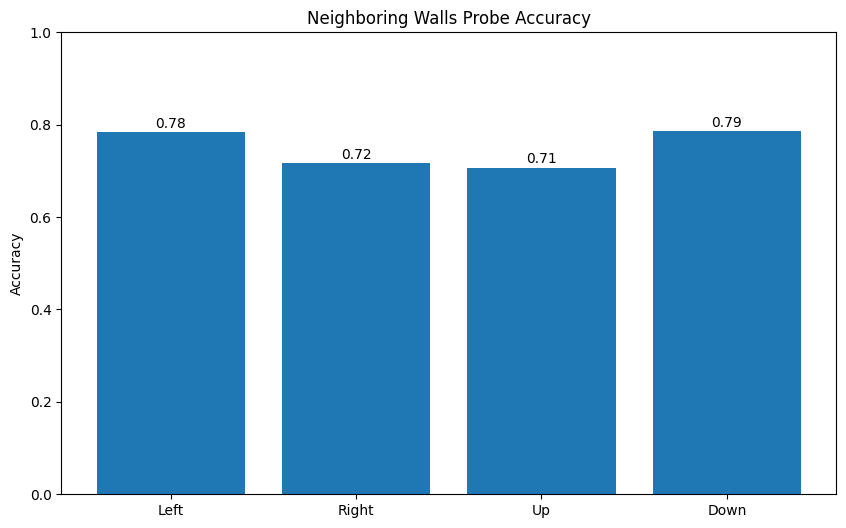

Original dataset size: 4000
Filtered dataset size: 3182
Removed 818 observations with fewer than 5 actions


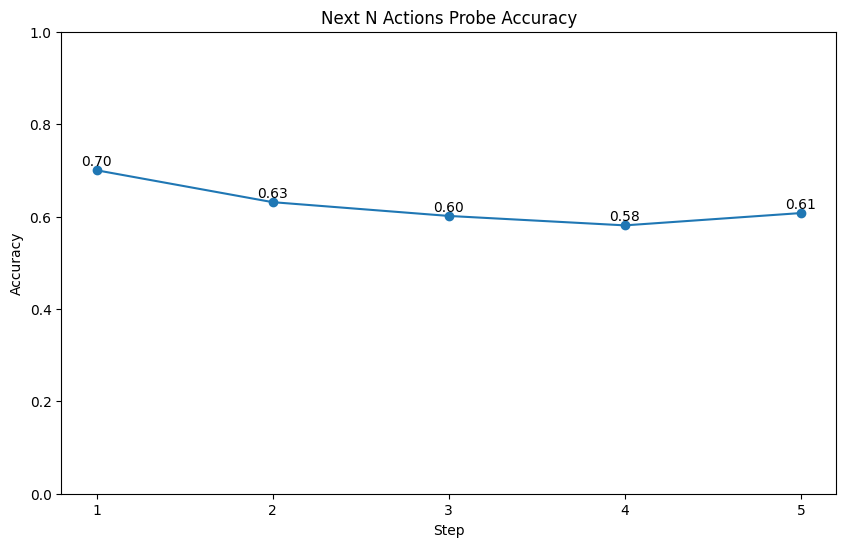

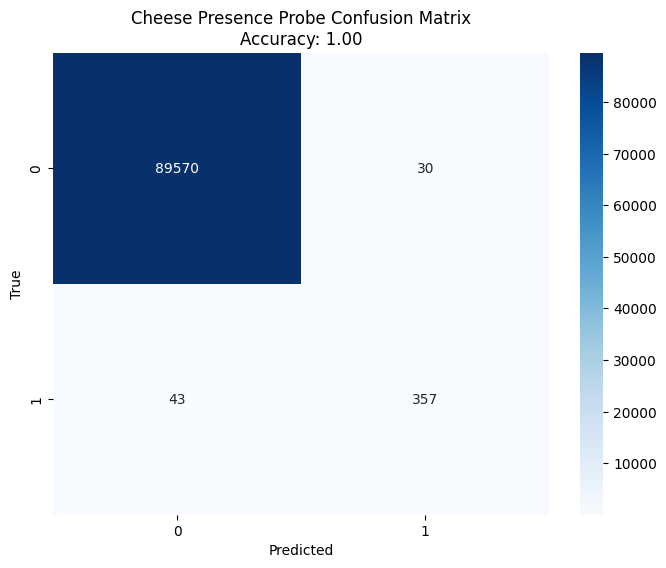

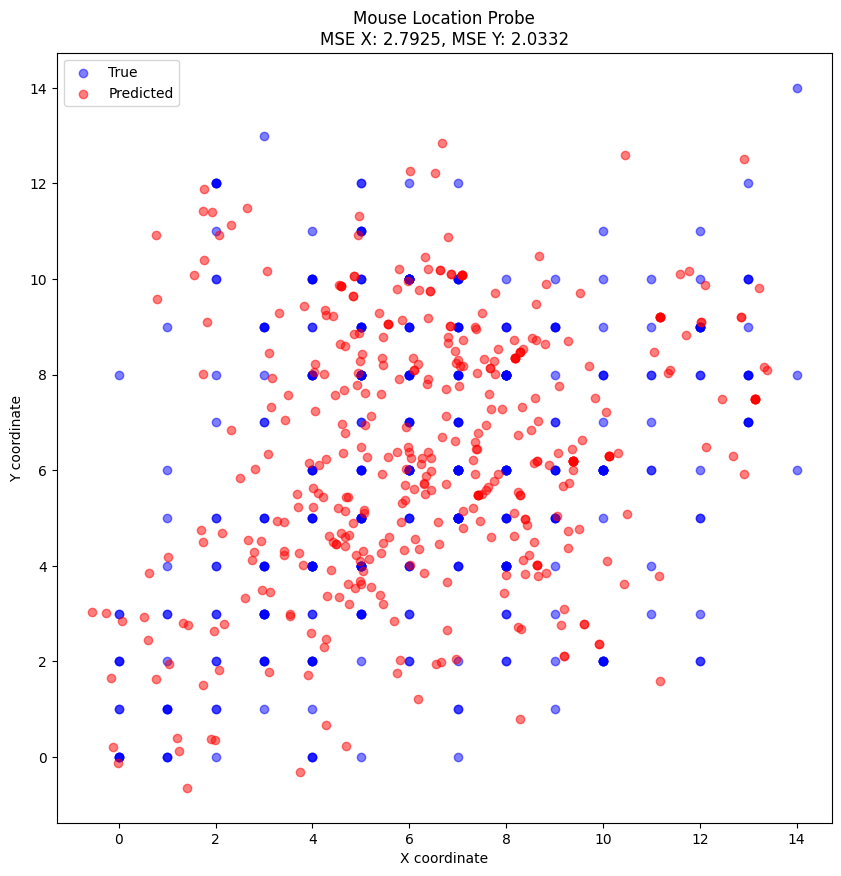

Visualizing results for layer: conv_seqs_1_res_block0_conv1


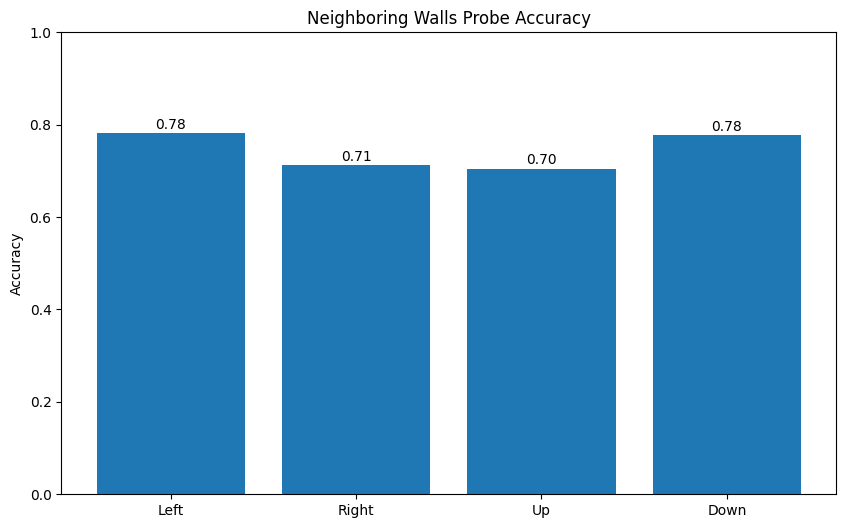

Original dataset size: 4000
Filtered dataset size: 3182
Removed 818 observations with fewer than 5 actions


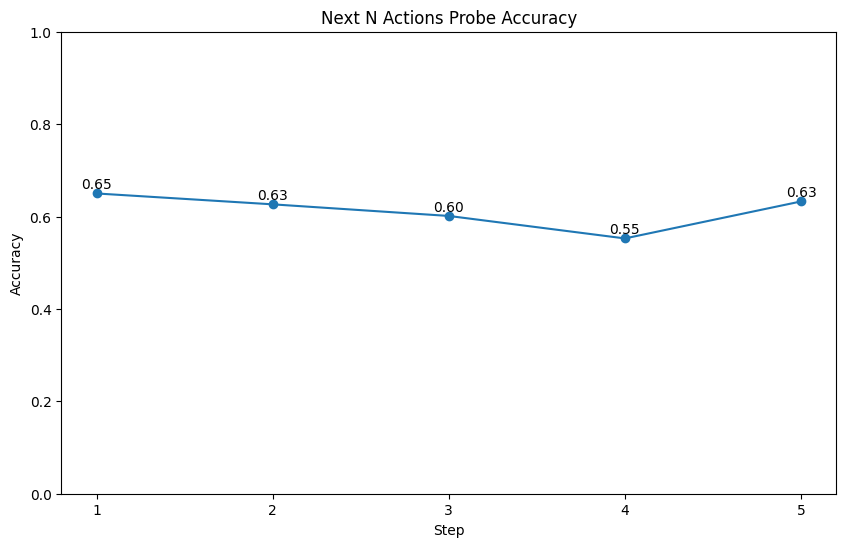

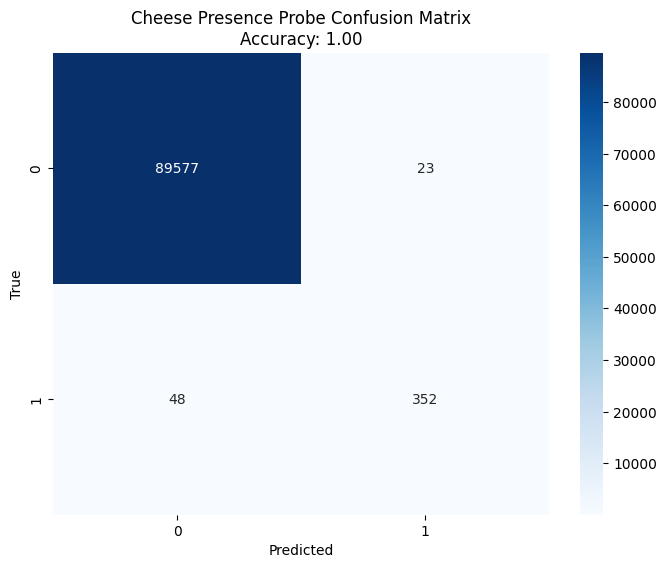

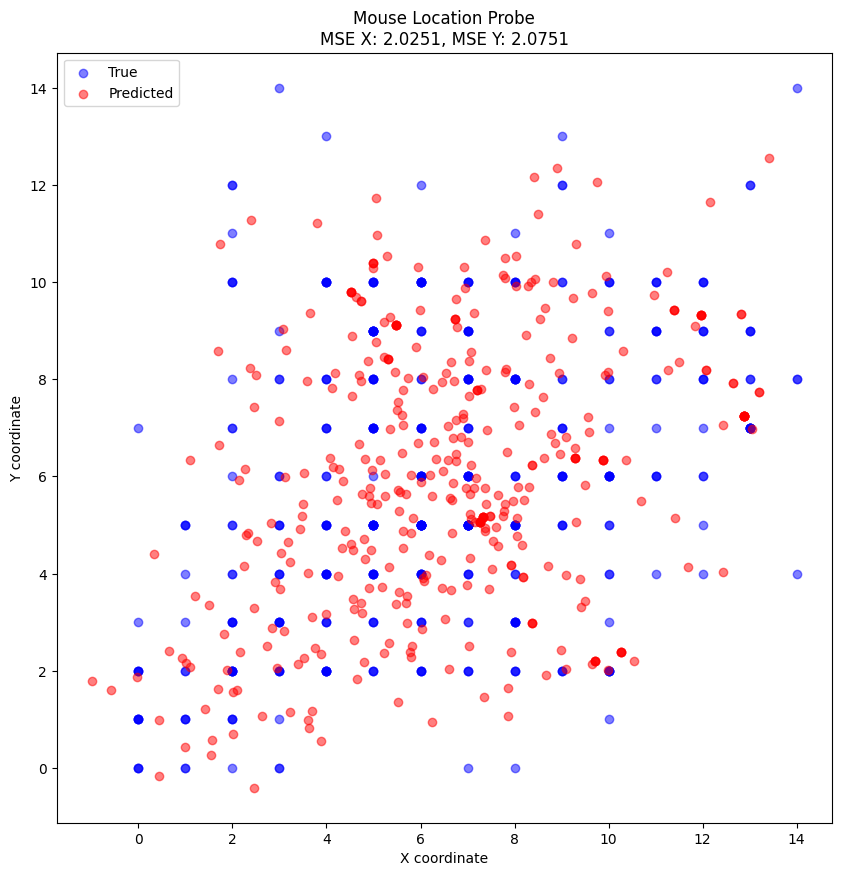

Visualizing results for layer: conv_seqs_1_res_block1


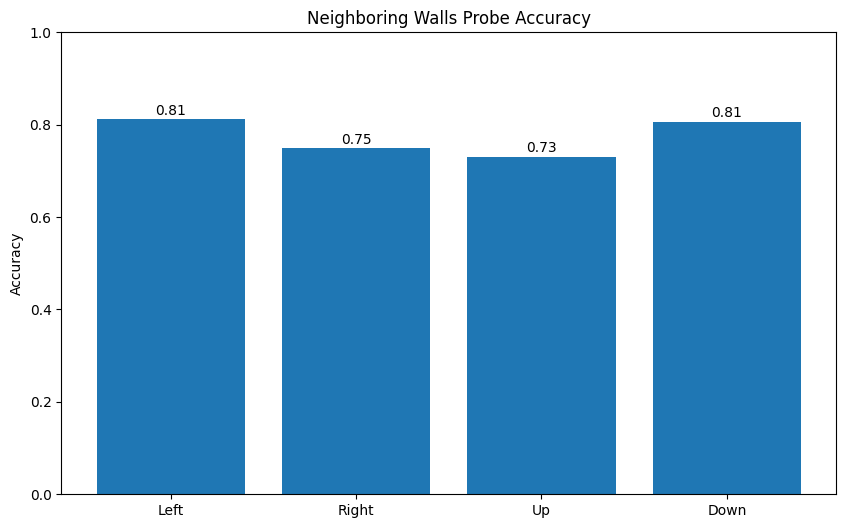

Original dataset size: 4000
Filtered dataset size: 3182
Removed 818 observations with fewer than 5 actions


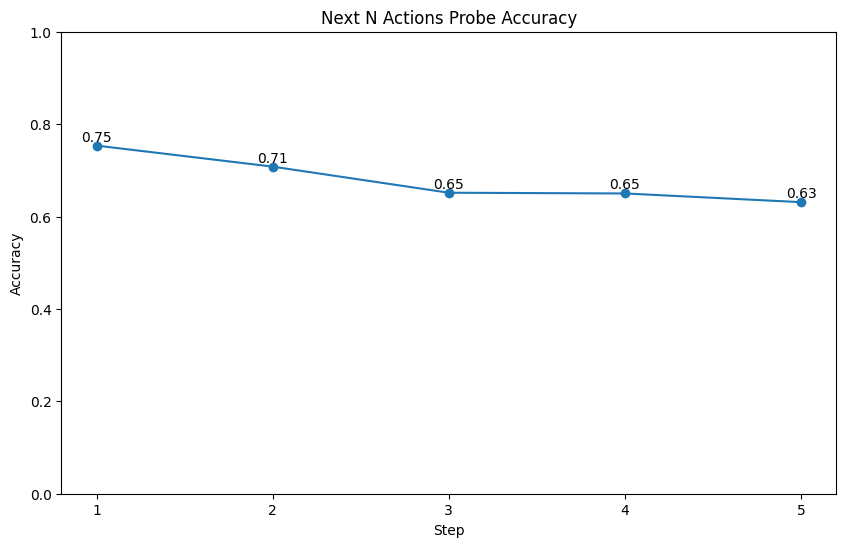

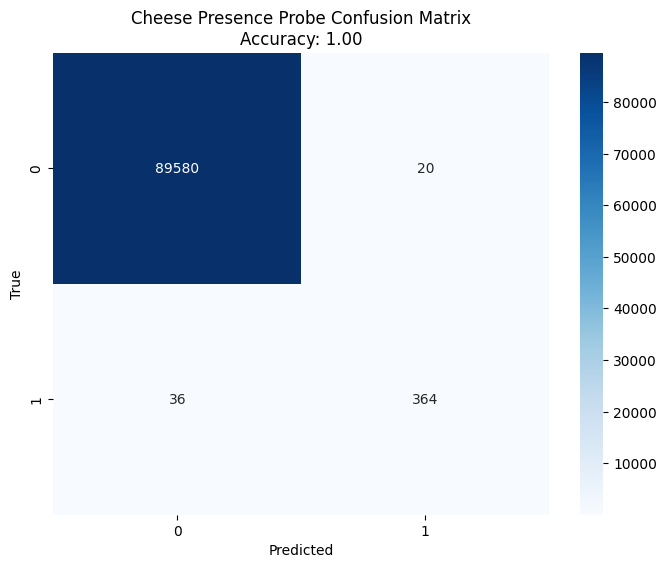

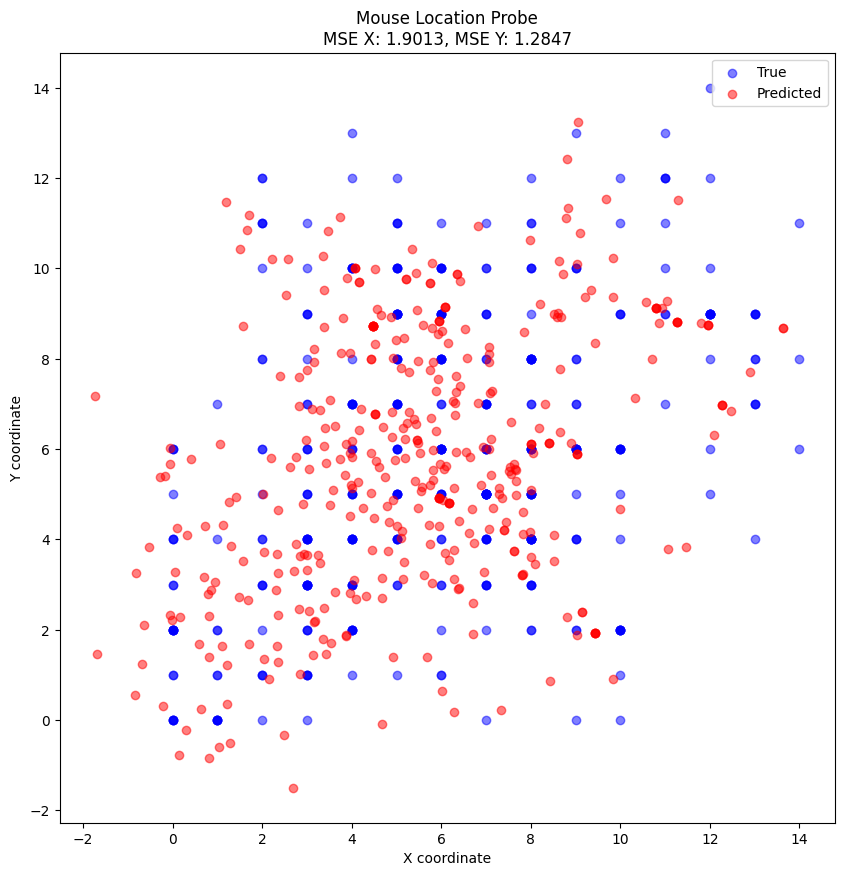

Visualizing results for layer: conv_seqs_1_res_block1_conv0


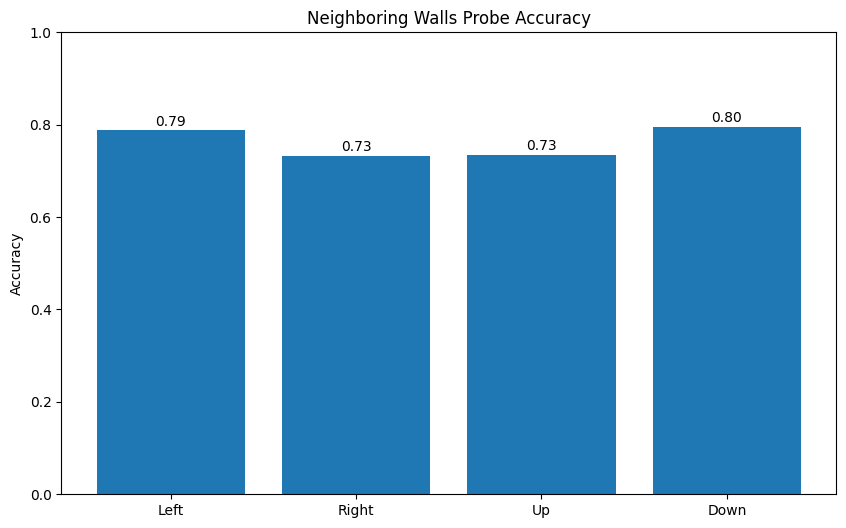

Original dataset size: 4000
Filtered dataset size: 3182
Removed 818 observations with fewer than 5 actions


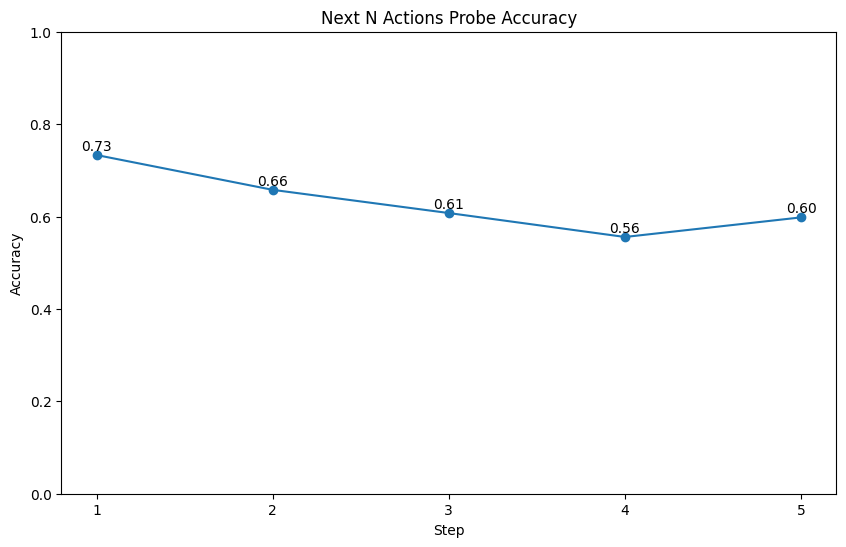

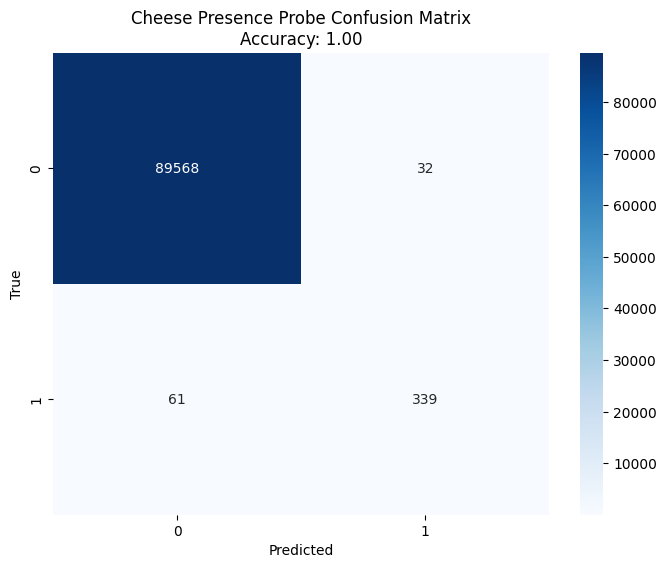

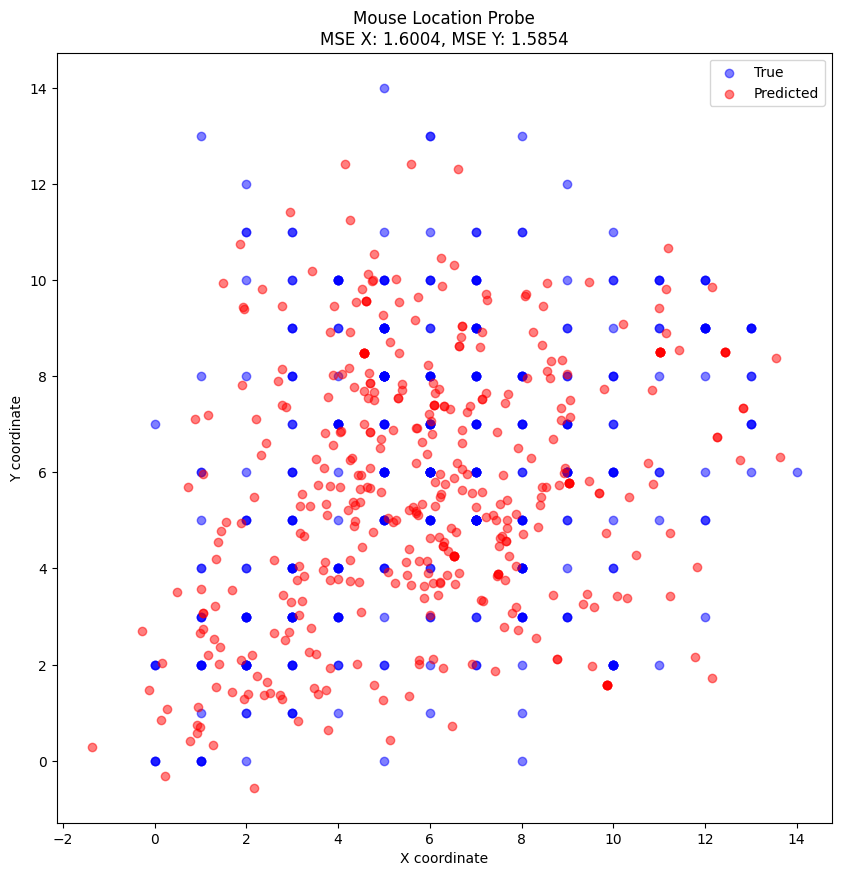

Visualizing results for layer: conv_seqs_1_res_block1_conv1


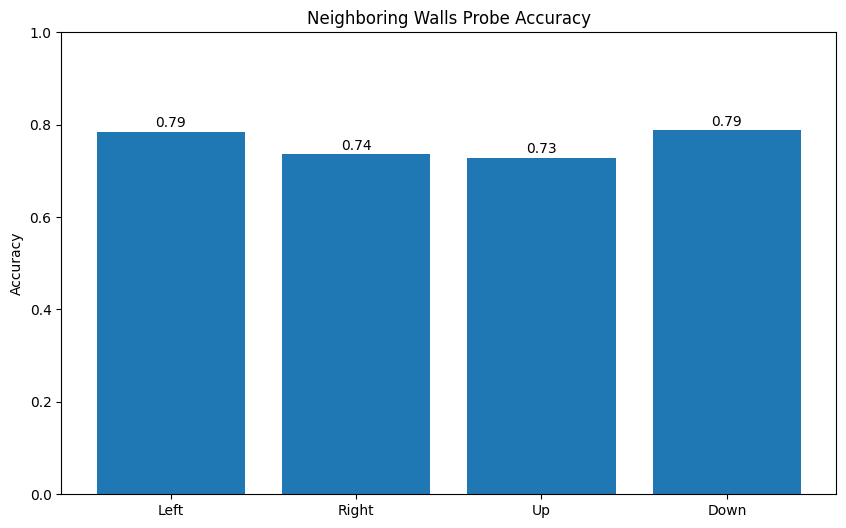

Original dataset size: 4000
Filtered dataset size: 3182
Removed 818 observations with fewer than 5 actions


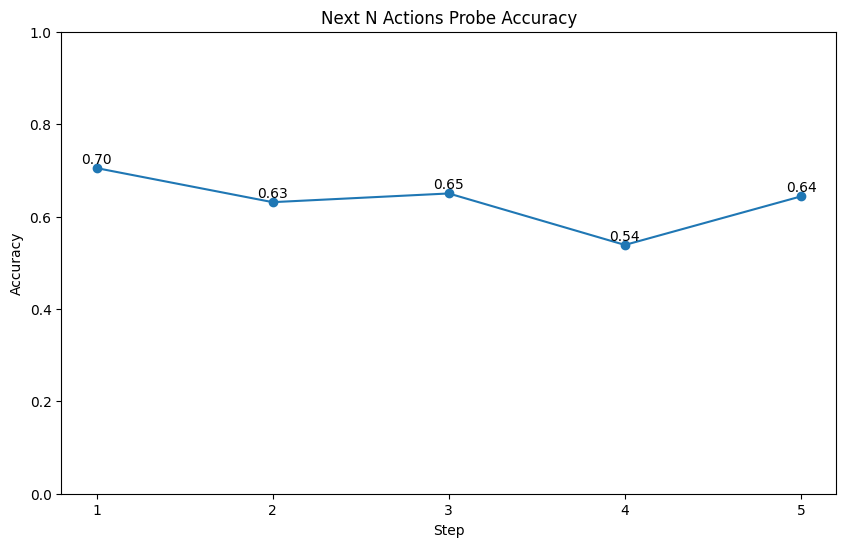

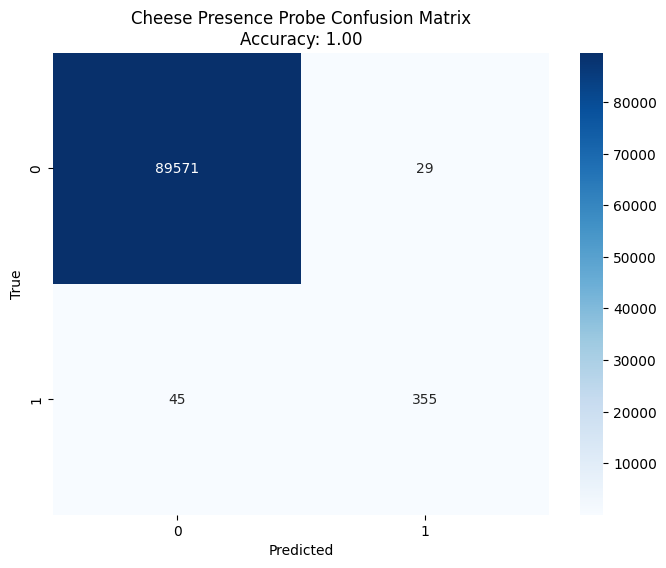

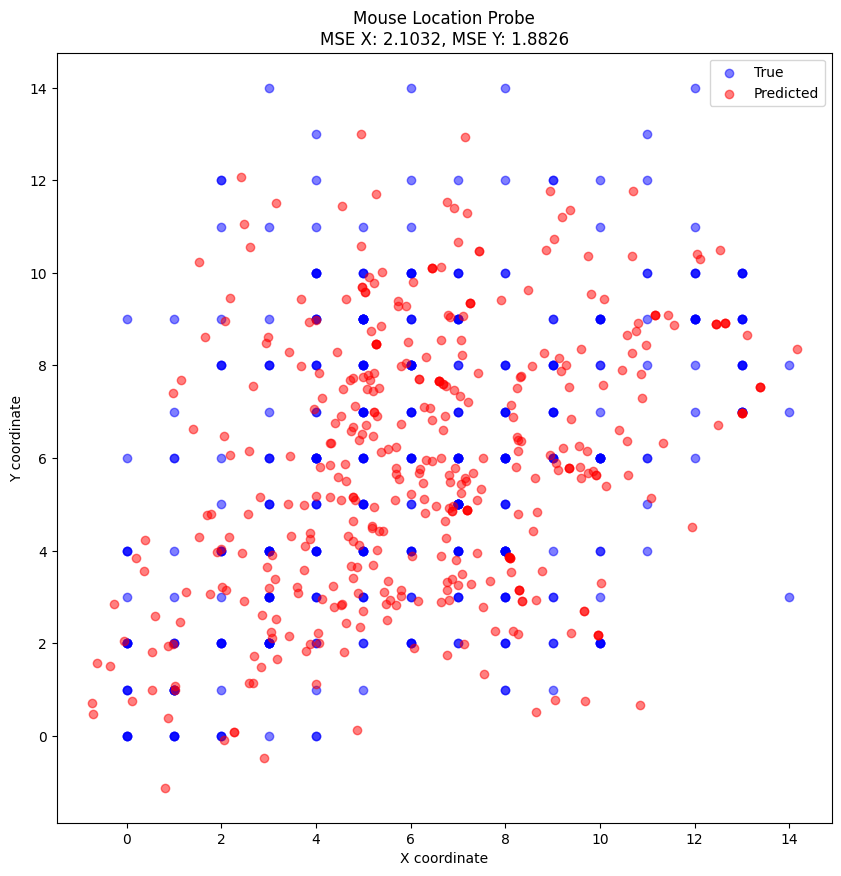

Visualizing results for layer: conv_seqs_2


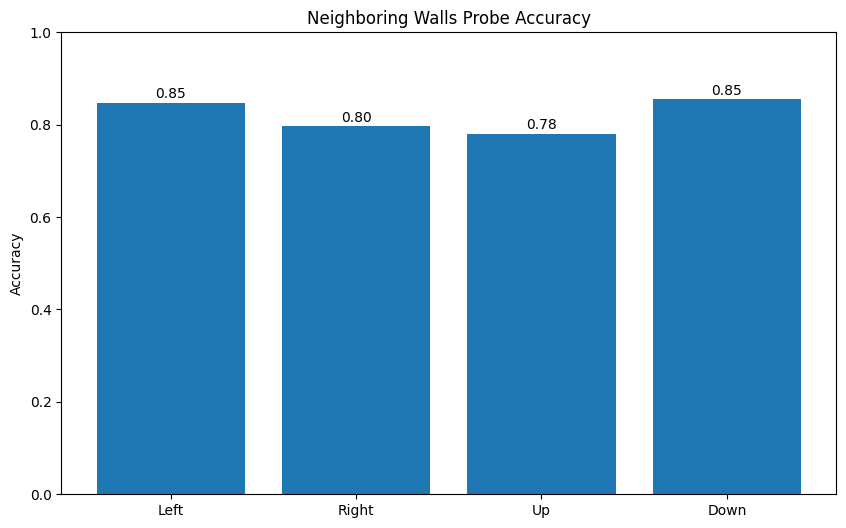

Original dataset size: 4000
Filtered dataset size: 3182
Removed 818 observations with fewer than 5 actions


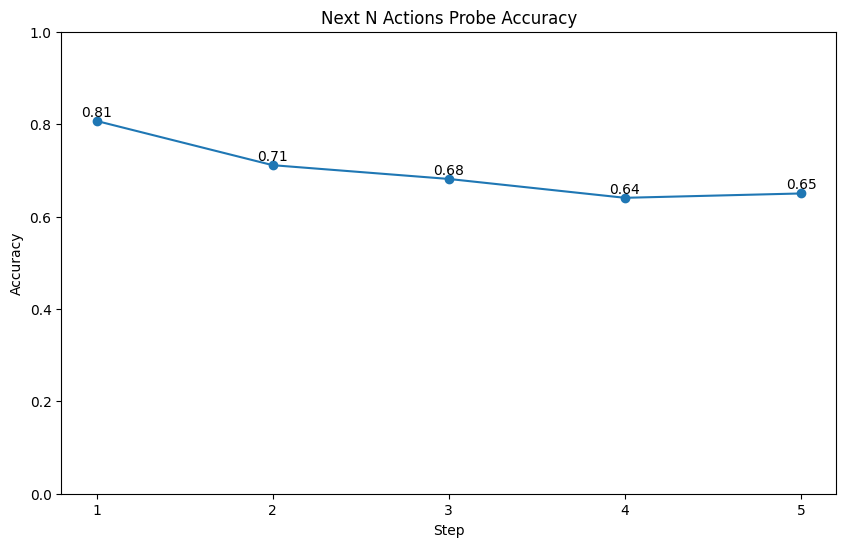

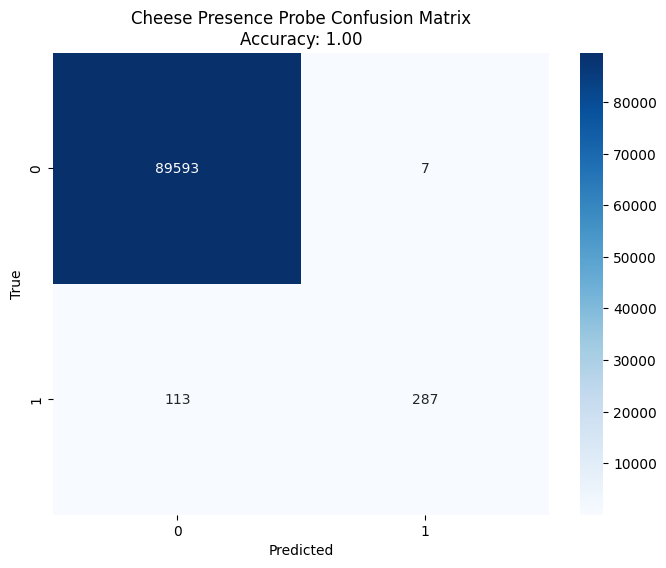

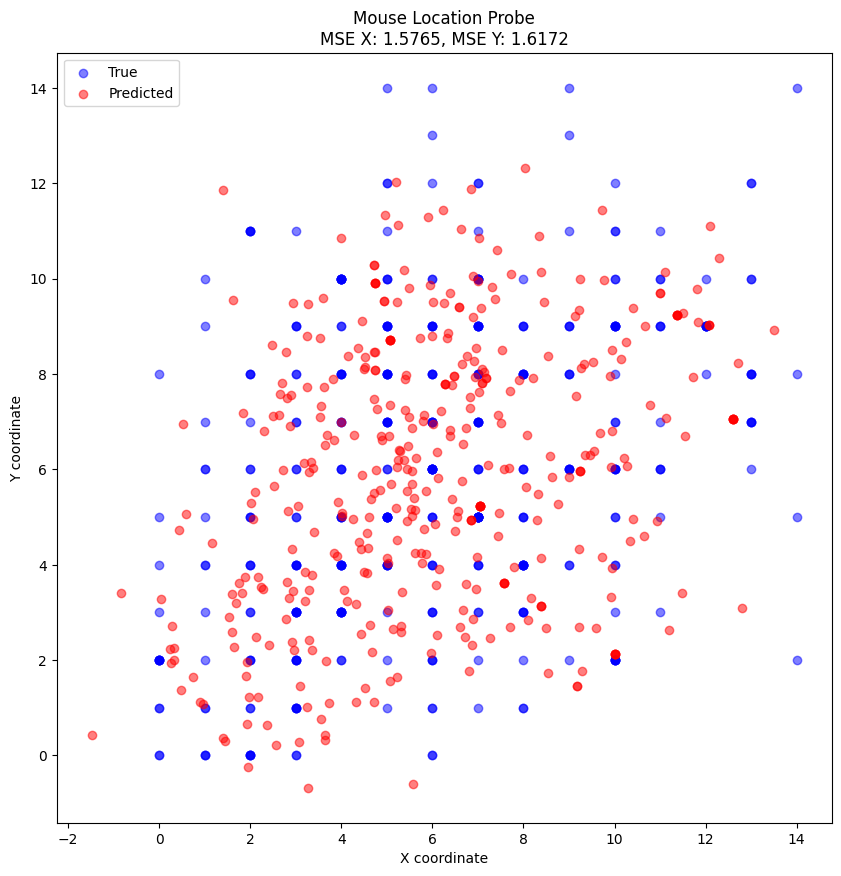

Visualizing results for layer: conv_seqs_2_max_pool2d


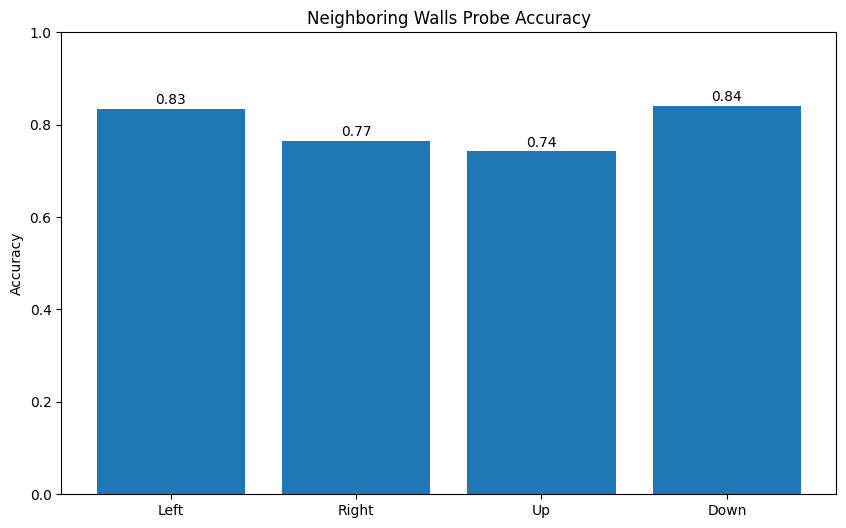

Original dataset size: 4000
Filtered dataset size: 3182
Removed 818 observations with fewer than 5 actions


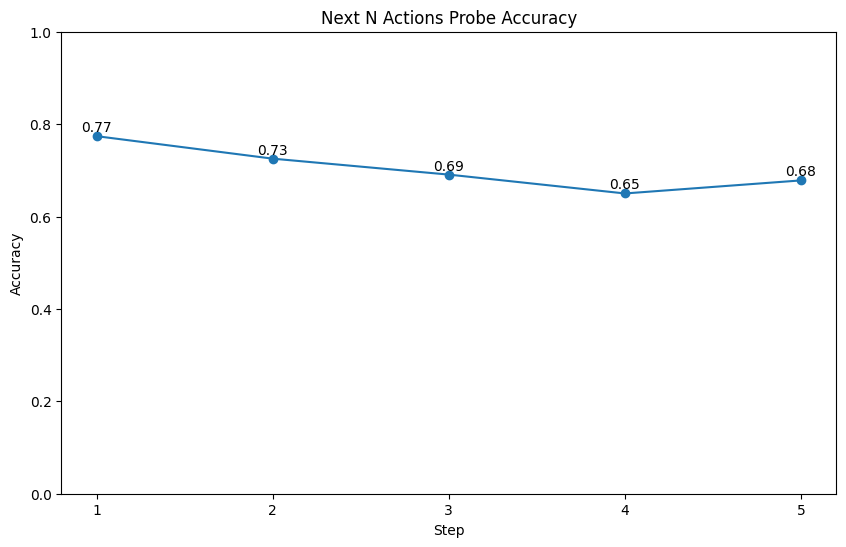

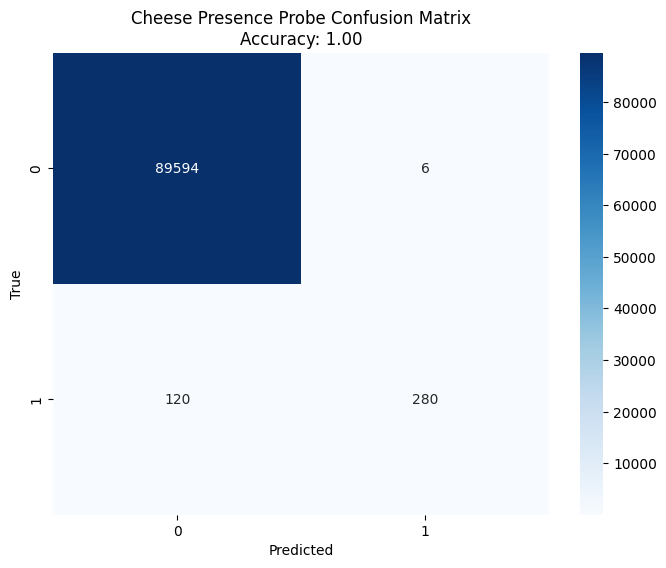

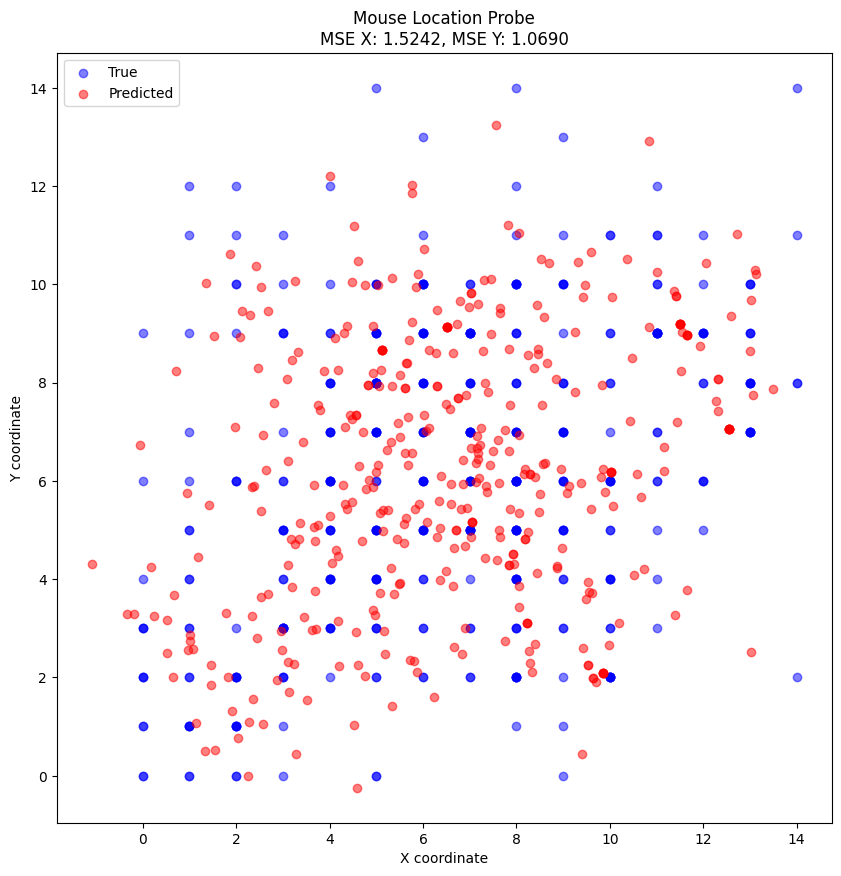

Visualizing results for layer: conv_seqs_2_res_block0


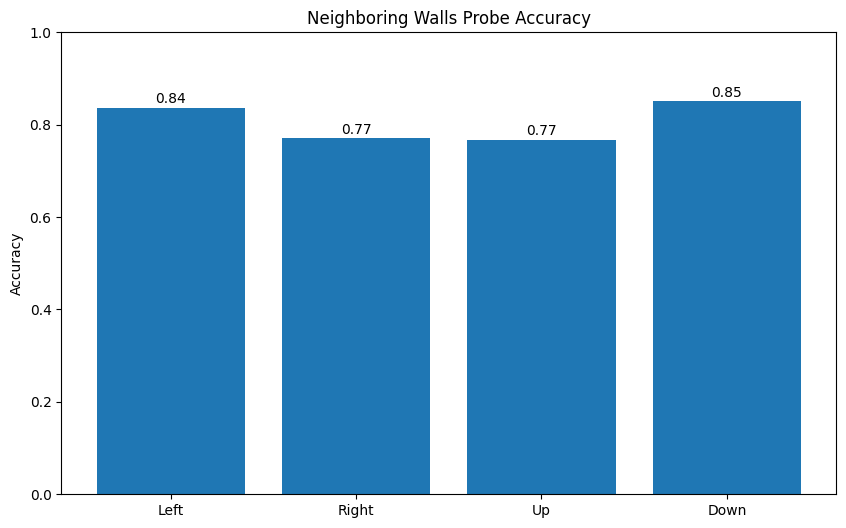

Original dataset size: 4000
Filtered dataset size: 3182
Removed 818 observations with fewer than 5 actions


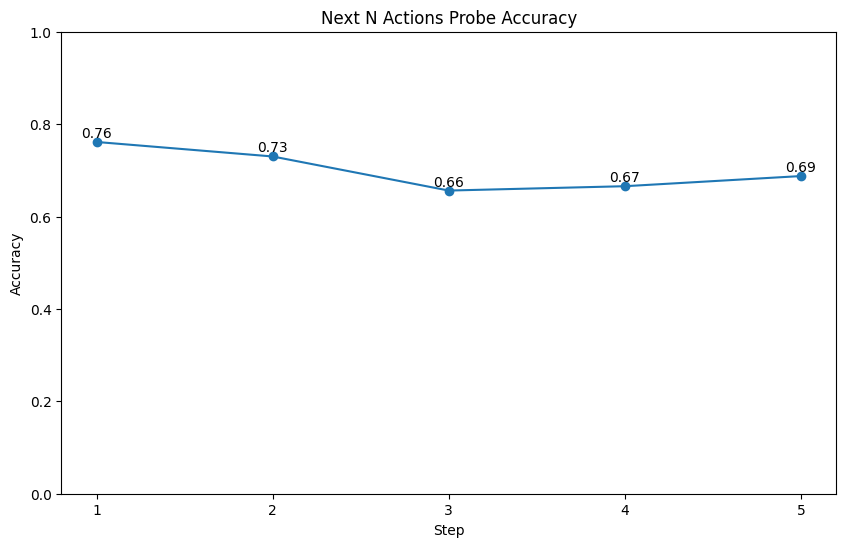

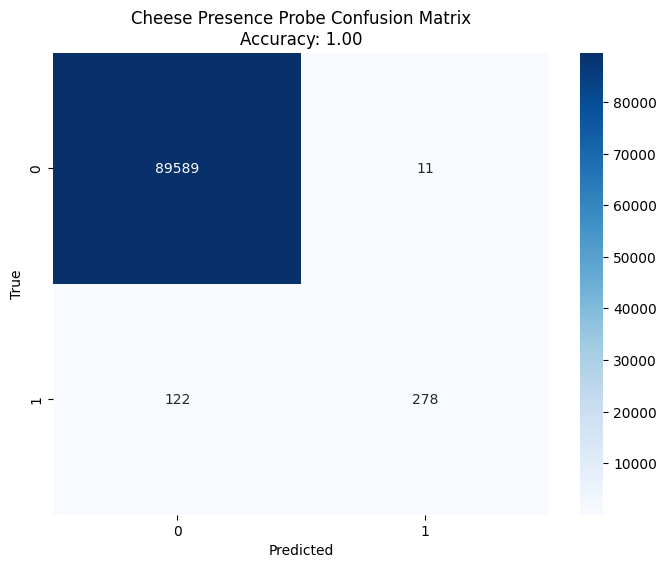

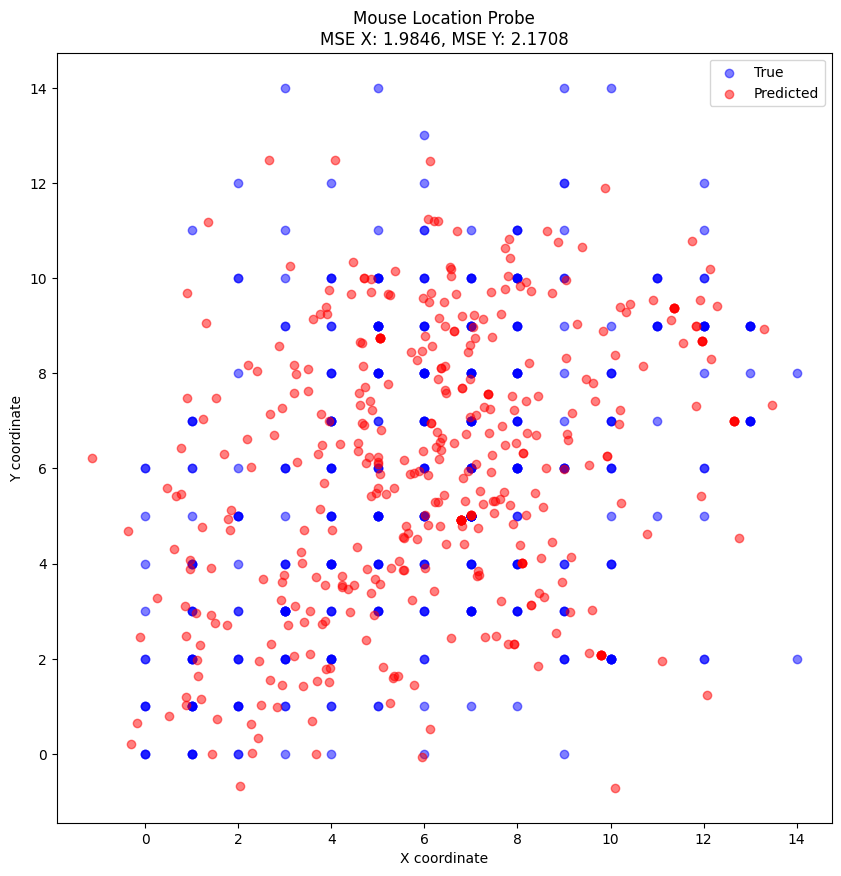

Visualizing results for layer: conv_seqs_2_res_block0_conv0


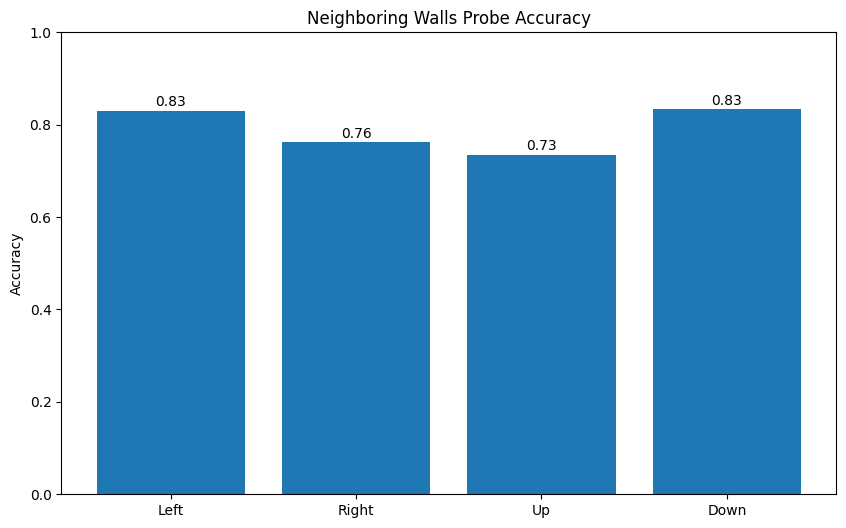

Original dataset size: 4000
Filtered dataset size: 3182
Removed 818 observations with fewer than 5 actions


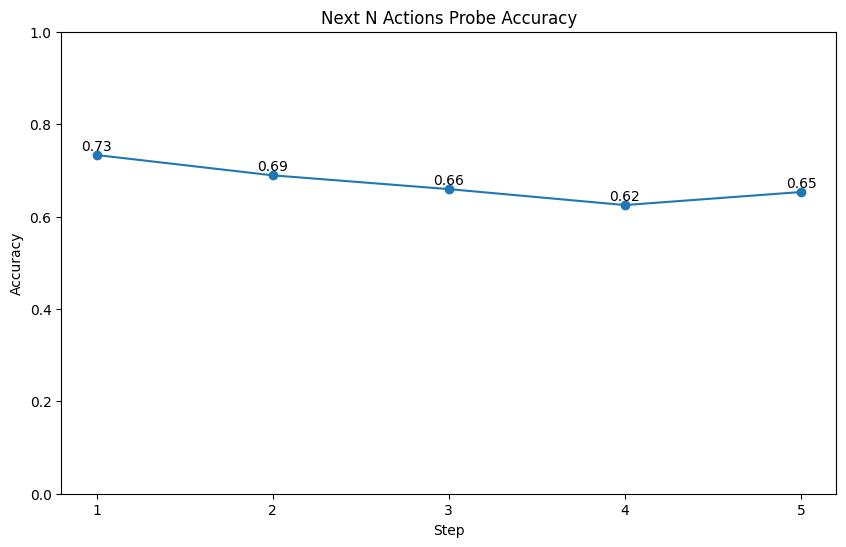

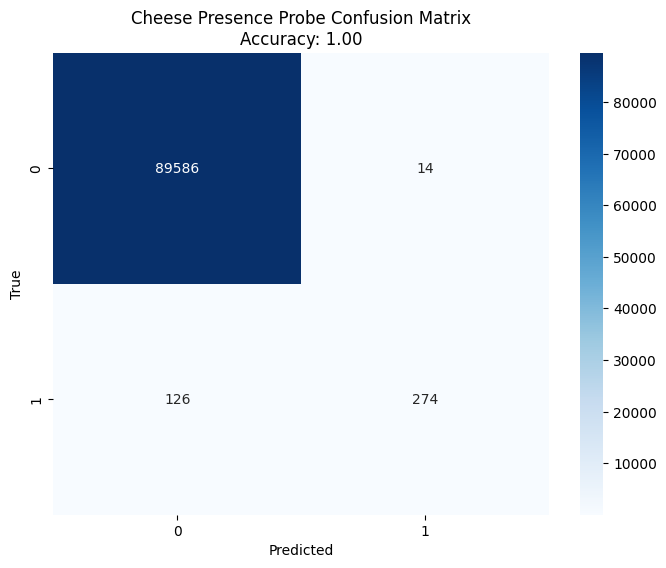

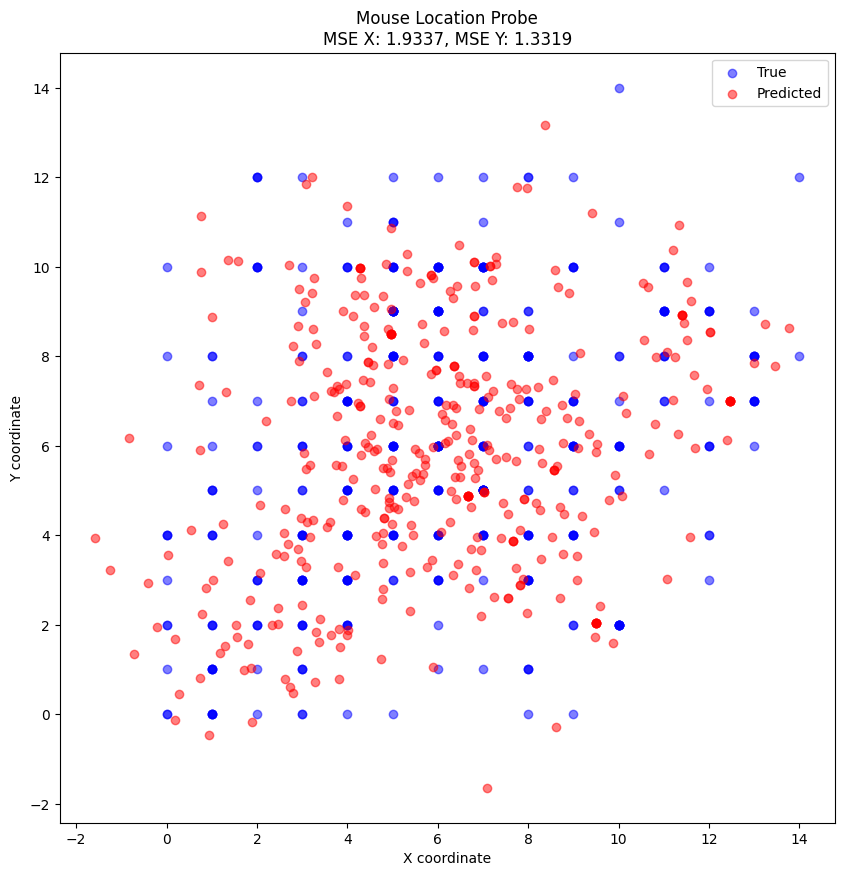

Visualizing results for layer: conv_seqs_2_res_block0_conv1


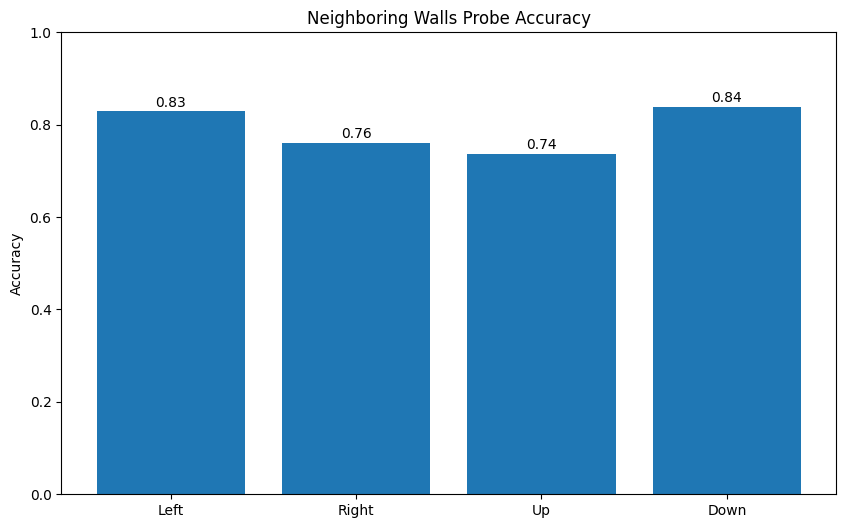

Original dataset size: 4000
Filtered dataset size: 3182
Removed 818 observations with fewer than 5 actions


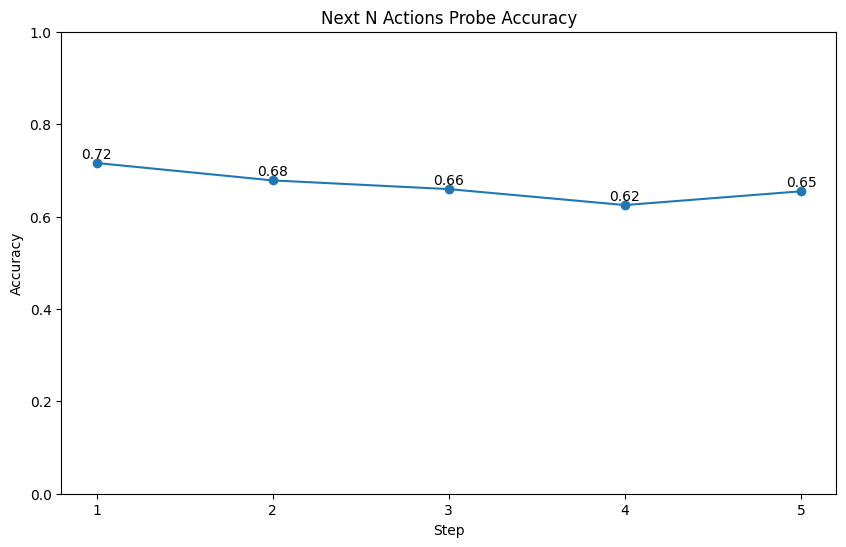

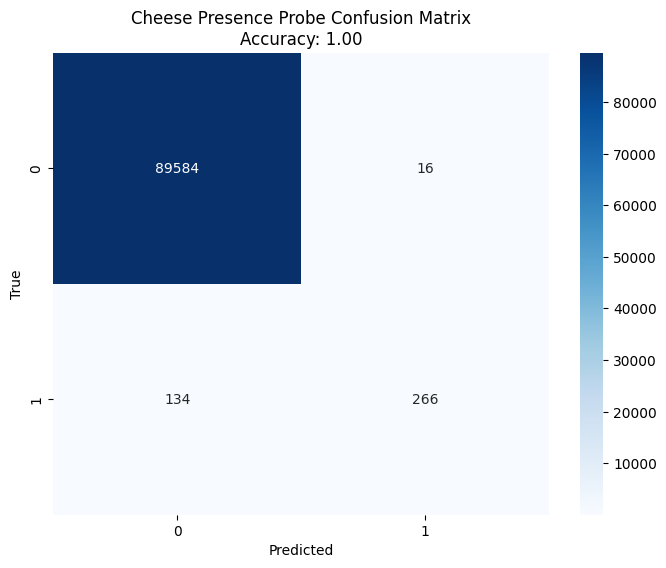

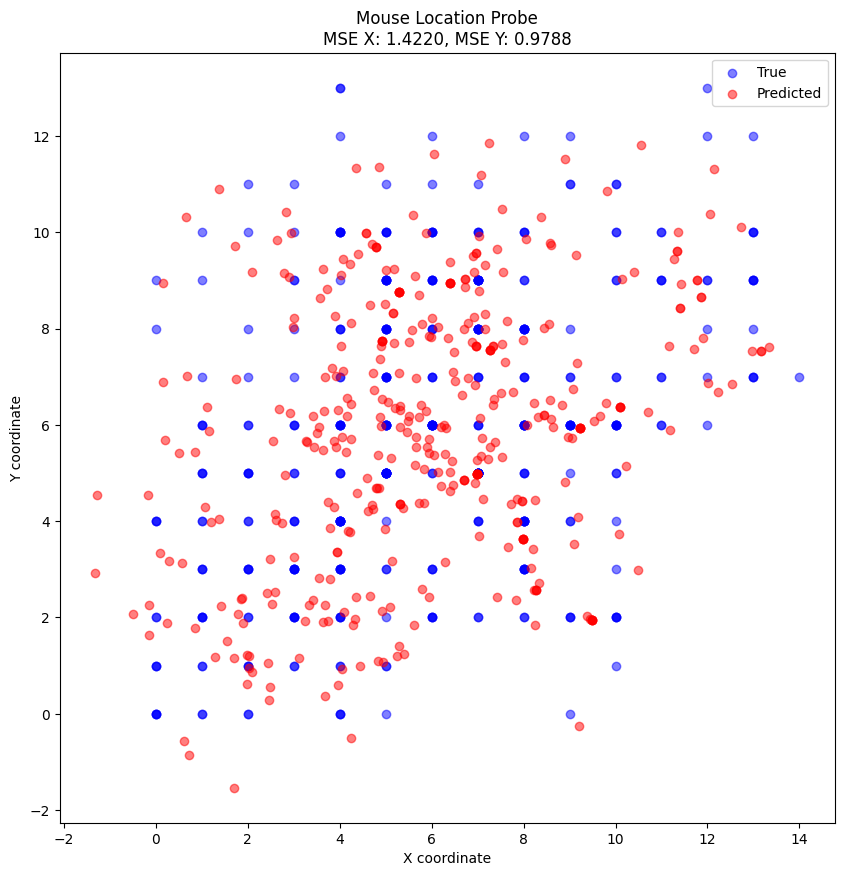

Visualizing results for layer: conv_seqs_2_res_block1


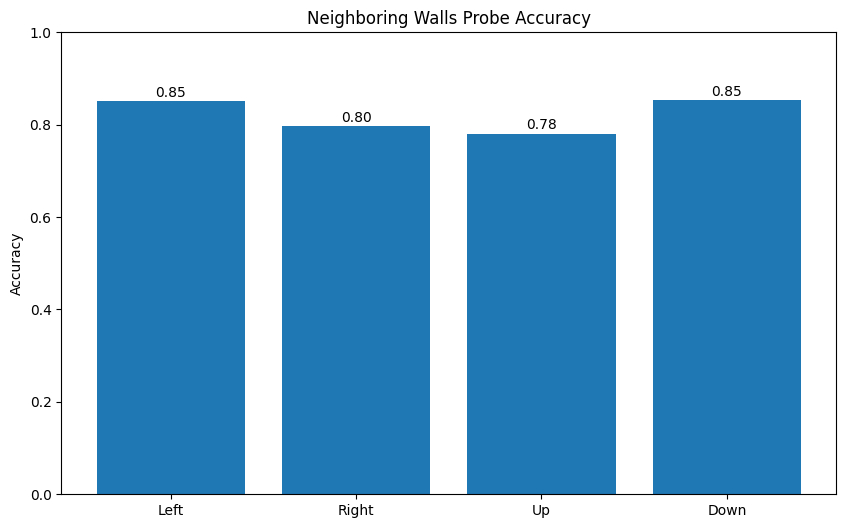

Original dataset size: 4000
Filtered dataset size: 3182
Removed 818 observations with fewer than 5 actions


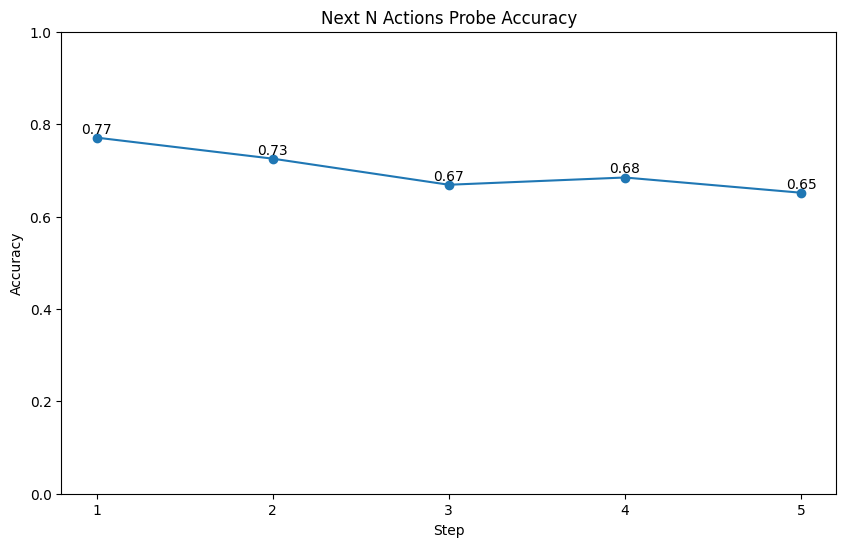

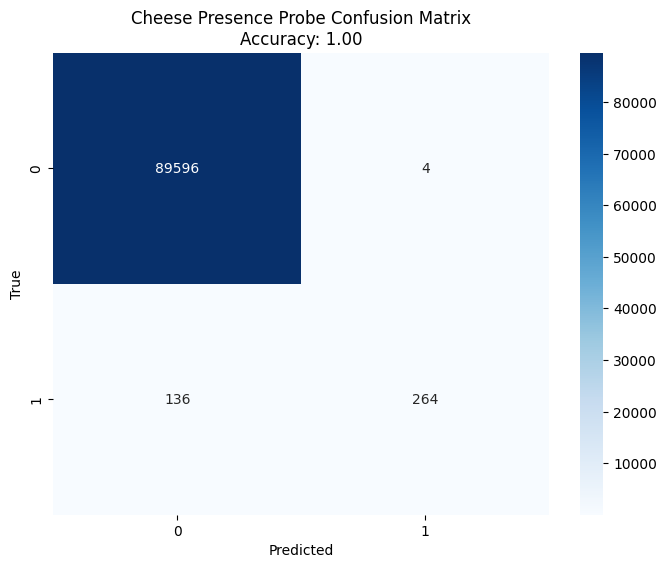

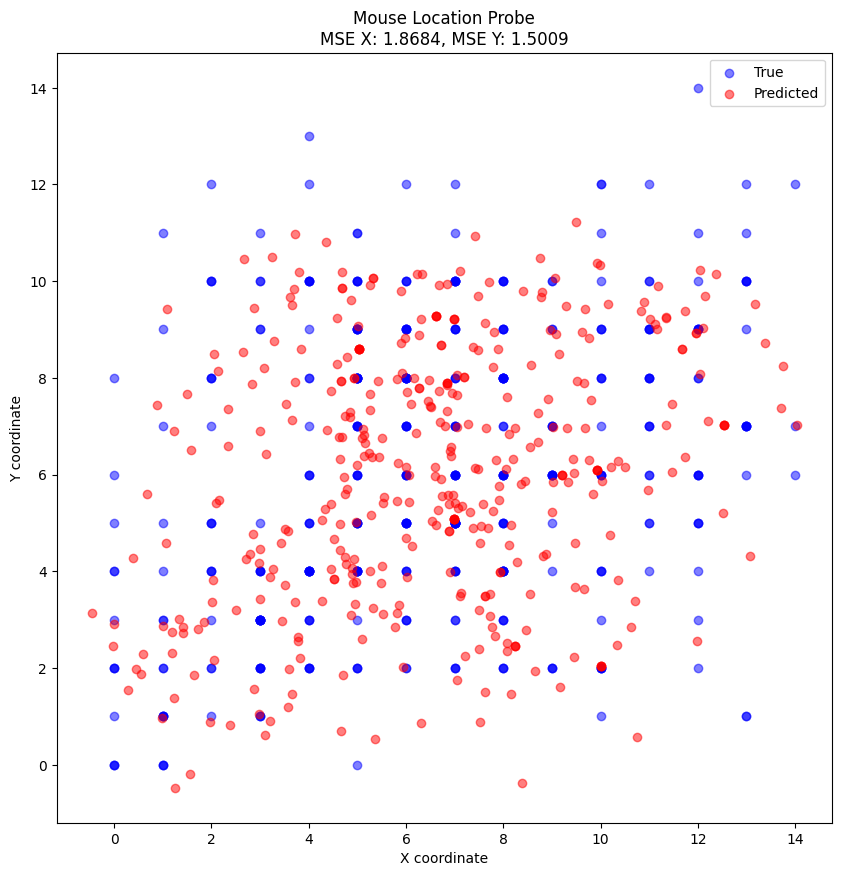

Visualizing results for layer: conv_seqs_2_res_block1_conv0


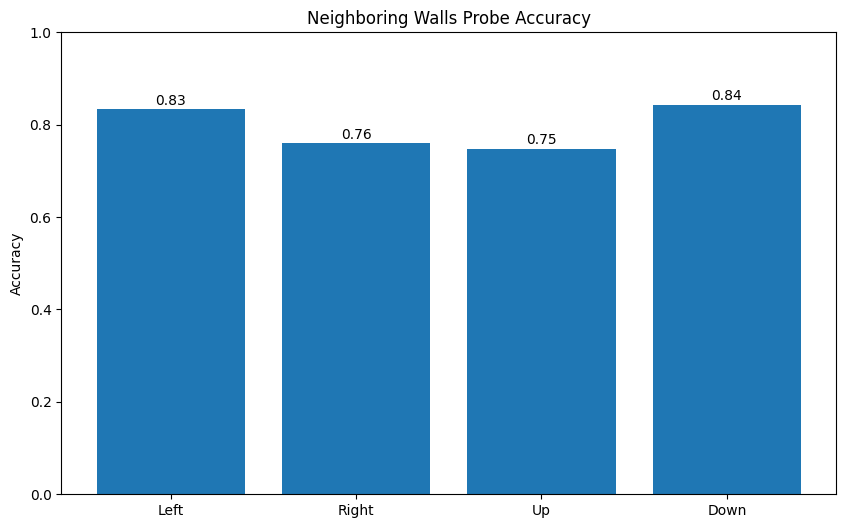

Original dataset size: 4000
Filtered dataset size: 3182
Removed 818 observations with fewer than 5 actions


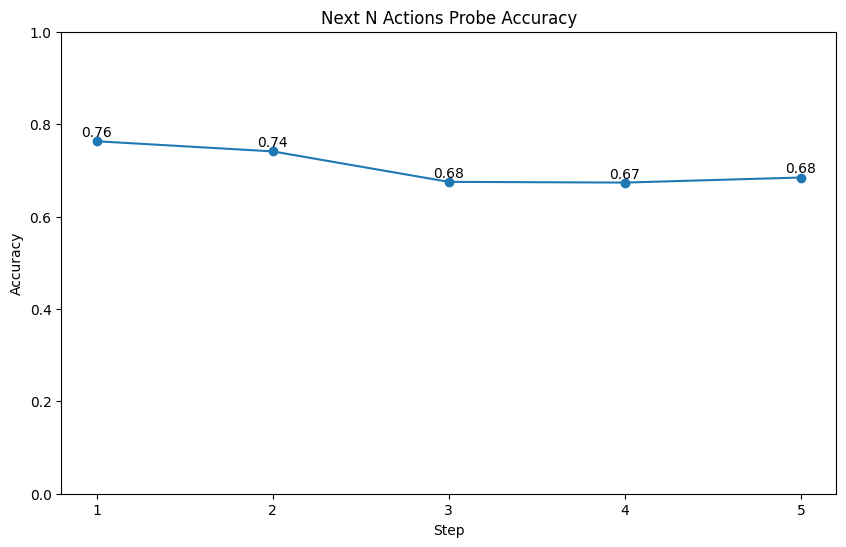

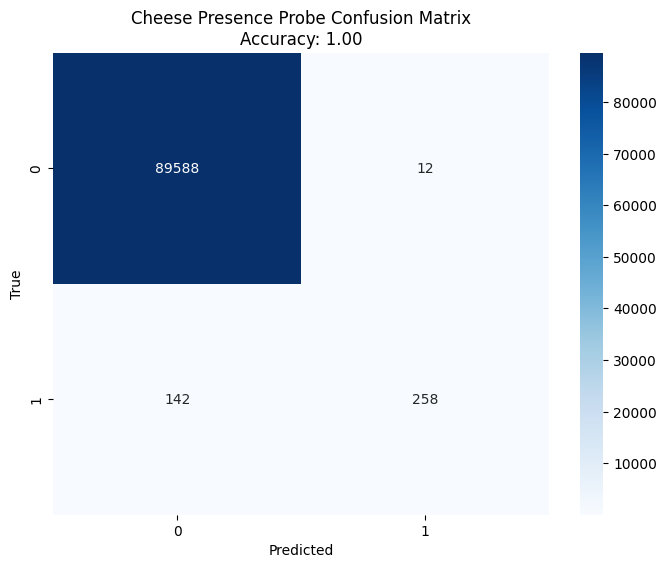

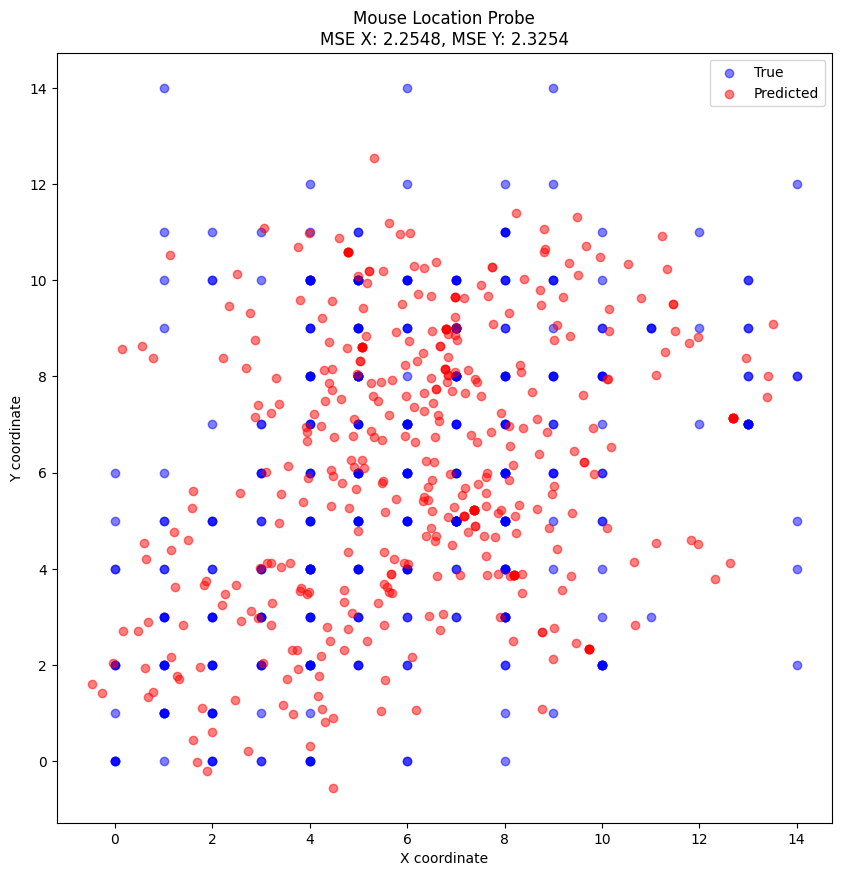

Visualizing results for layer: conv_seqs_2_res_block1_conv1


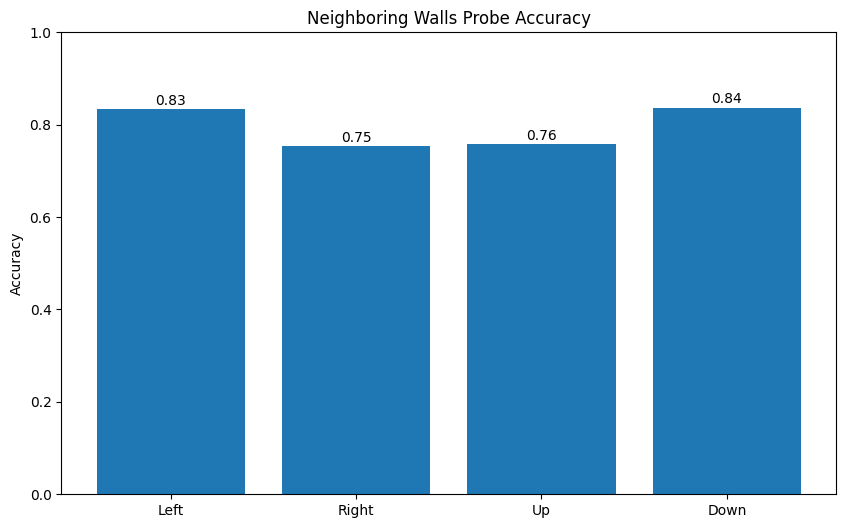

Original dataset size: 4000
Filtered dataset size: 3182
Removed 818 observations with fewer than 5 actions


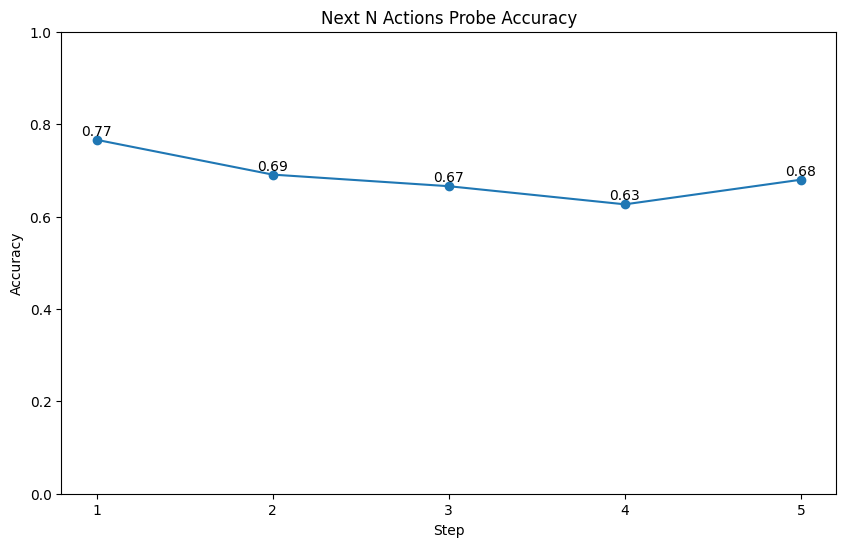

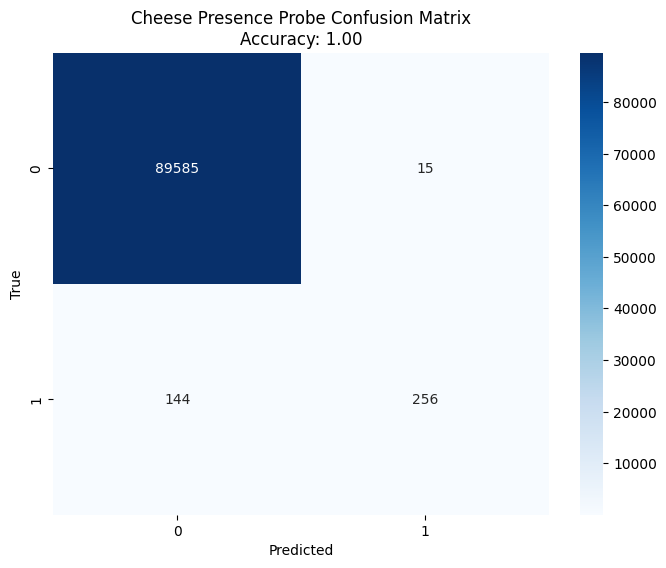

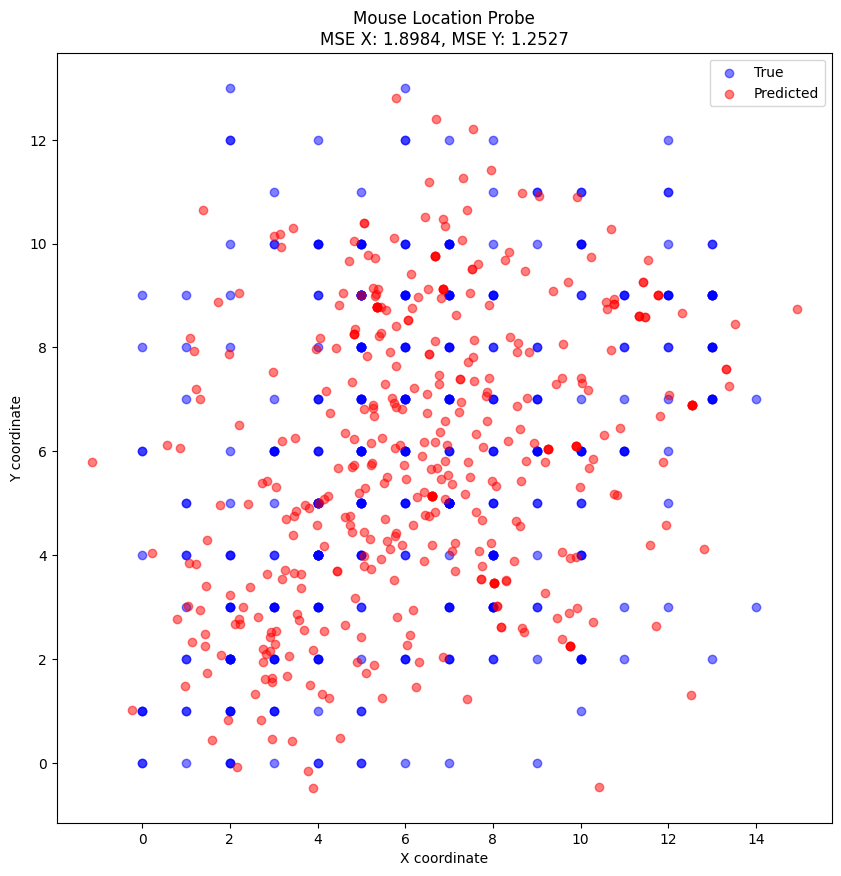

Visualizing results for layer: hidden_fc1


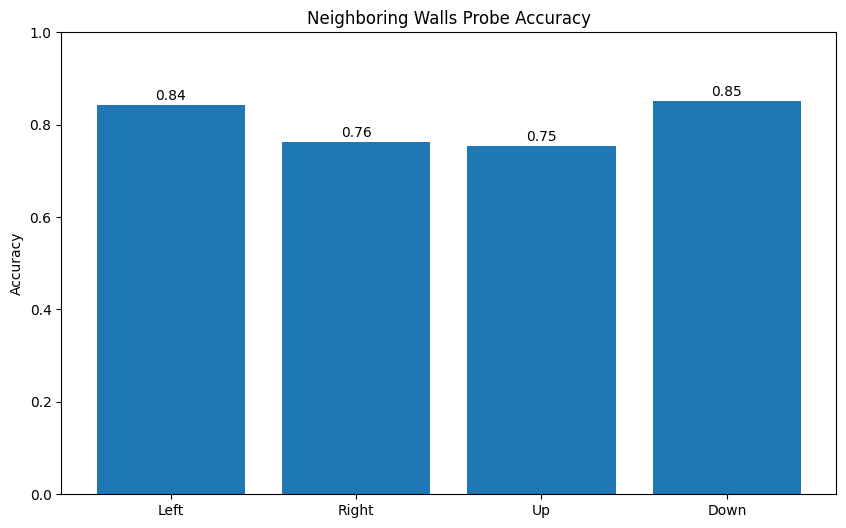

Original dataset size: 4000
Filtered dataset size: 3182
Removed 818 observations with fewer than 5 actions


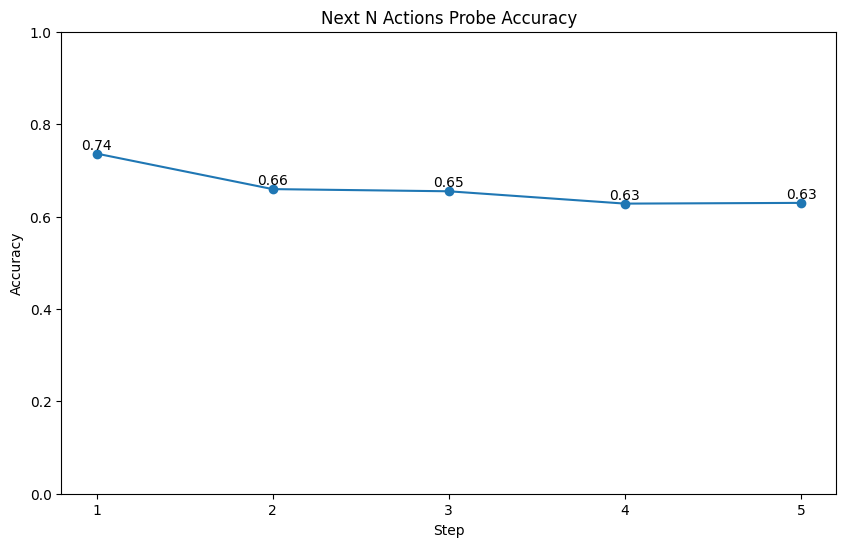

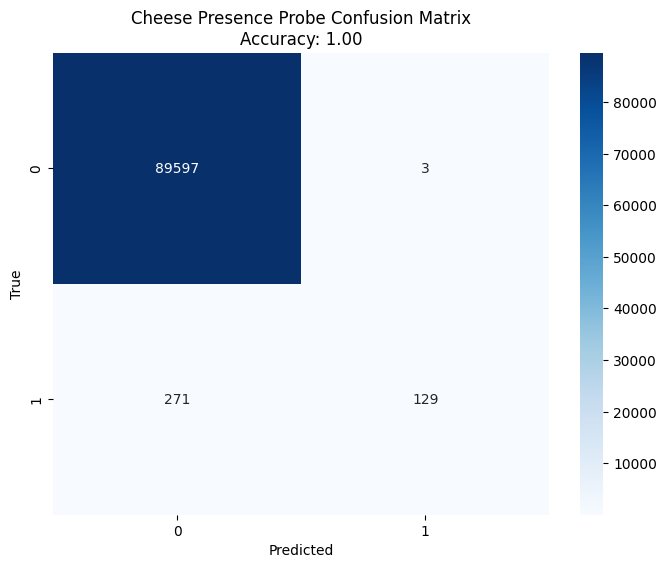

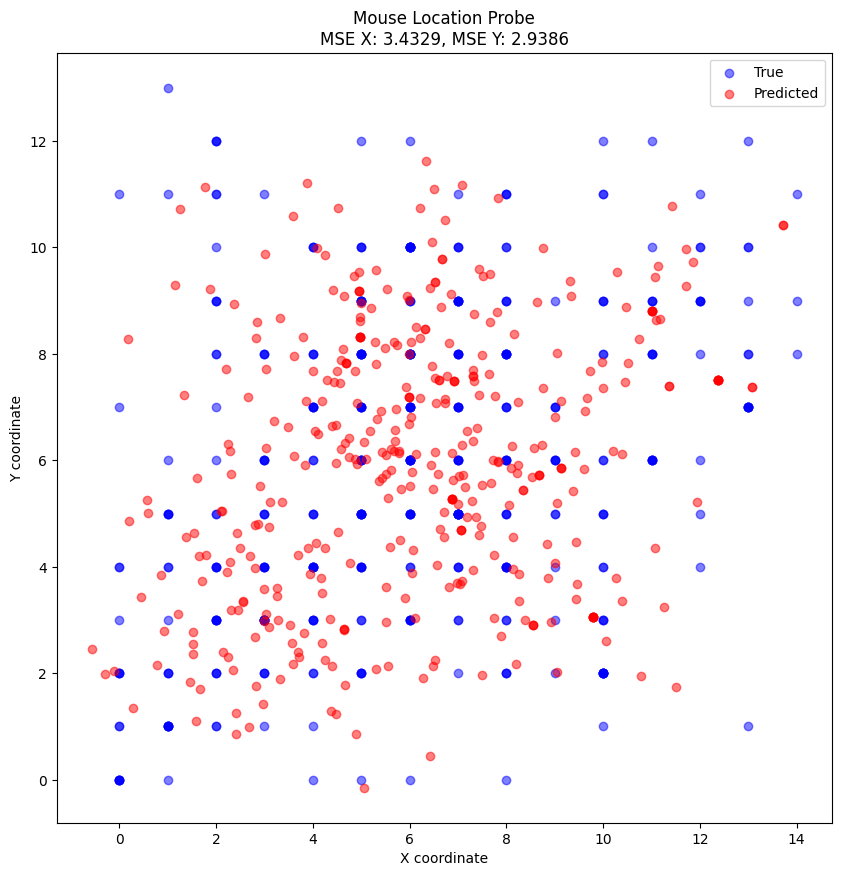

Visualizing results for layer: hidden_fc2


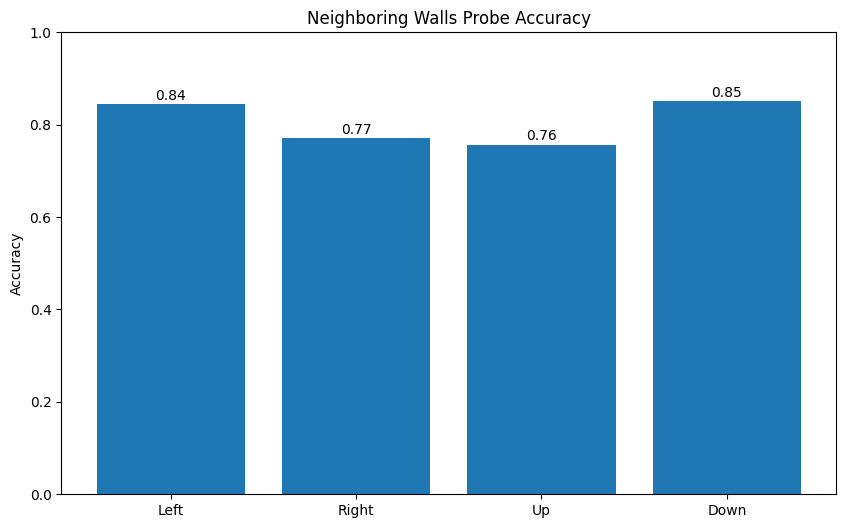

Original dataset size: 4000
Filtered dataset size: 3182
Removed 818 observations with fewer than 5 actions


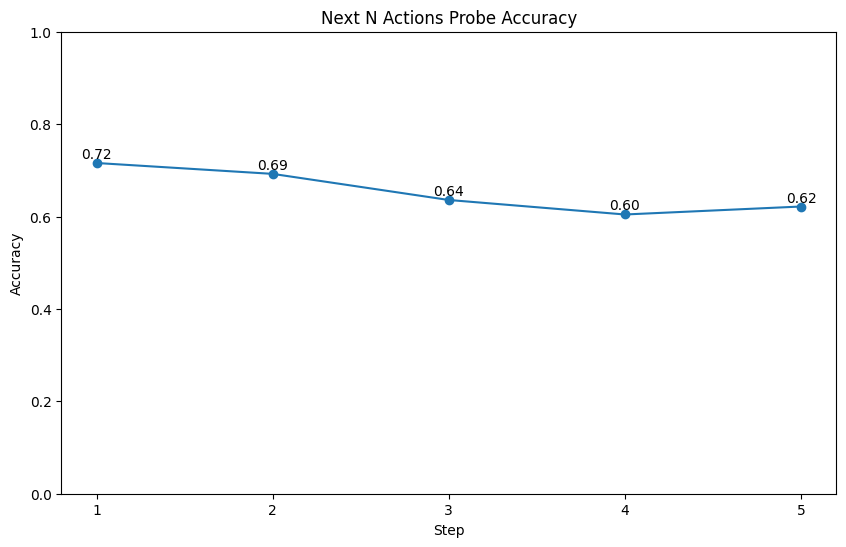

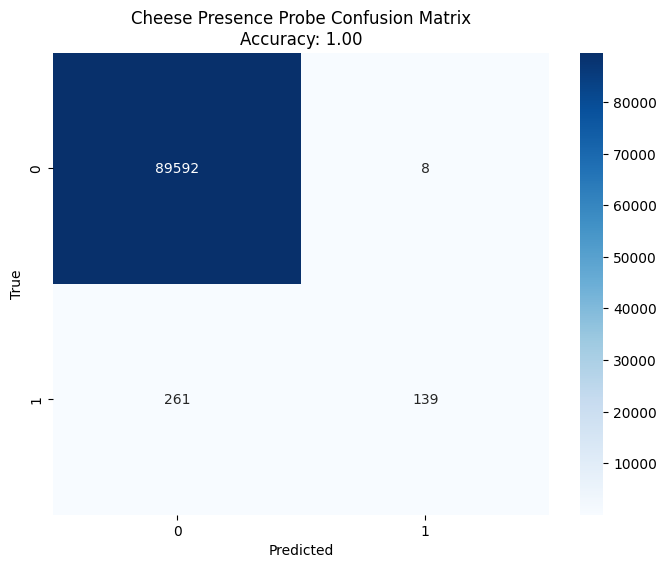

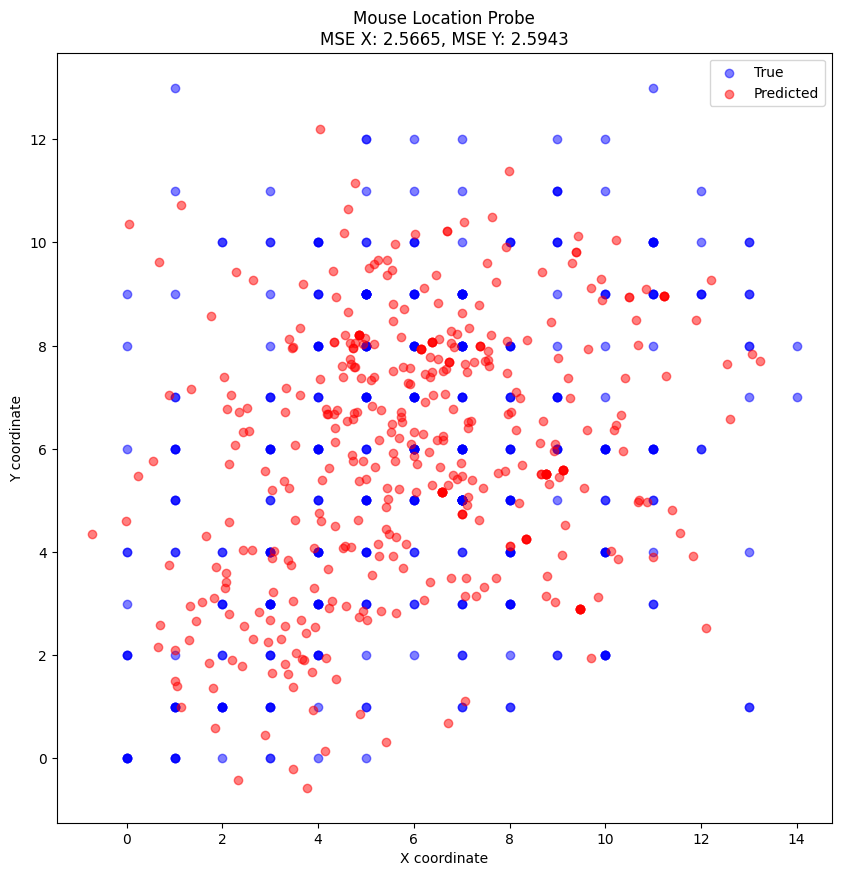

Visualizing results for layer: logits_fc


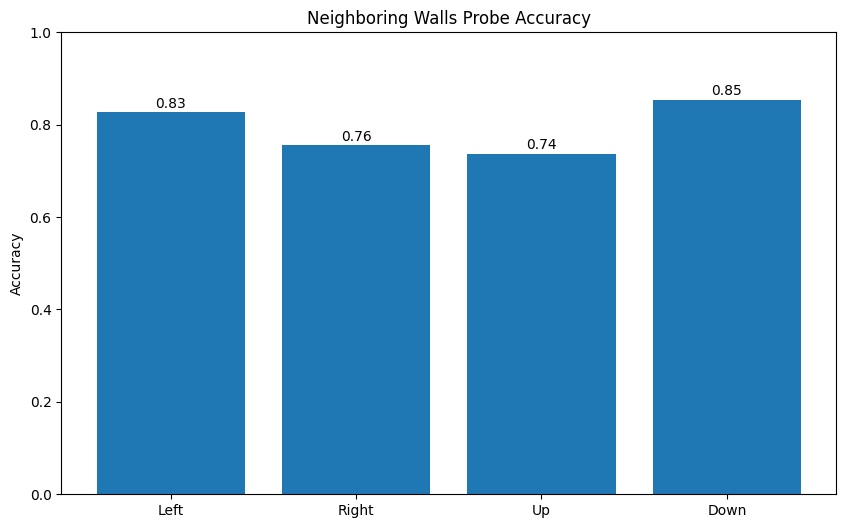

Original dataset size: 4000
Filtered dataset size: 3182
Removed 818 observations with fewer than 5 actions


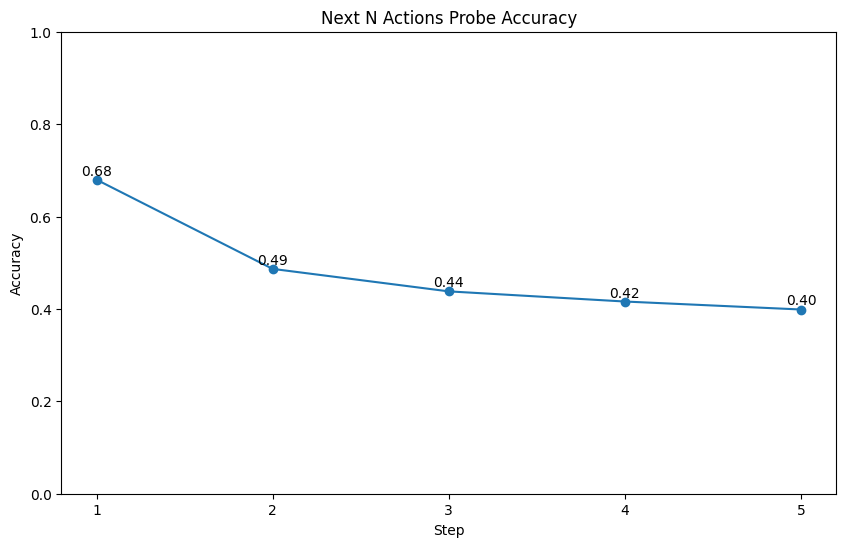

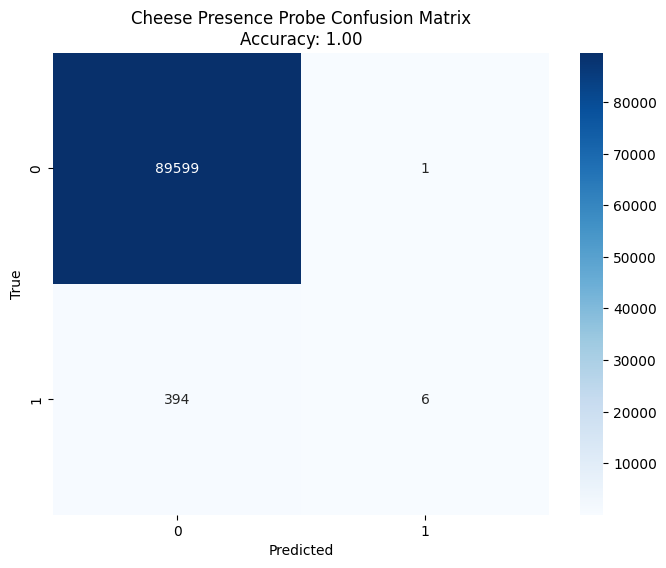

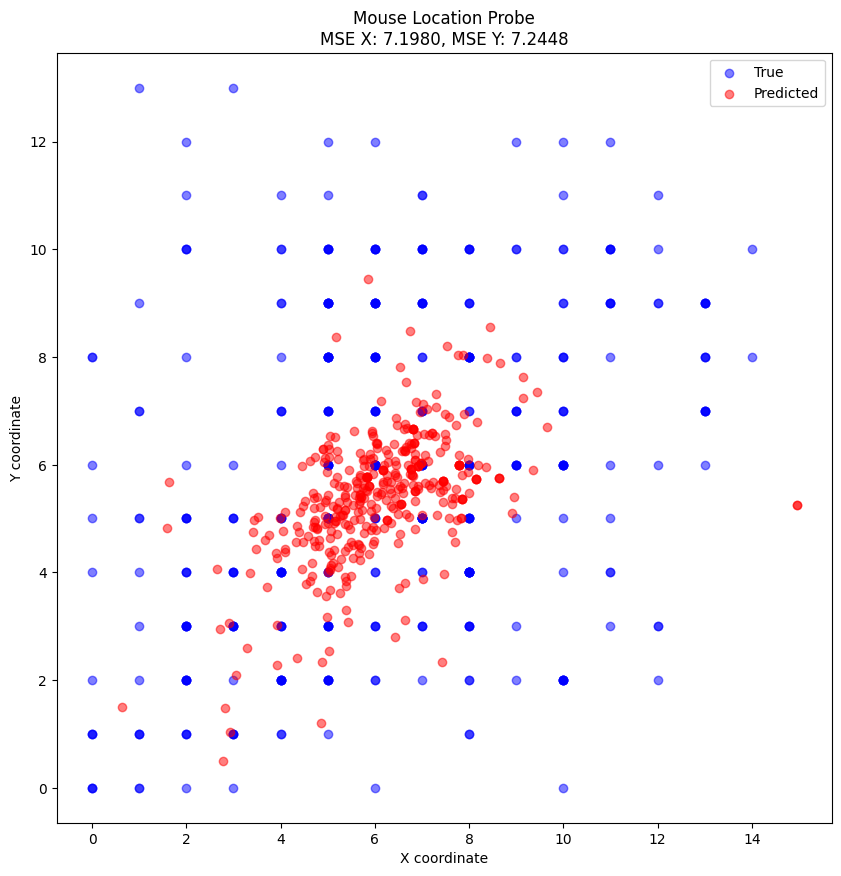

Visualizing results for layer: value_fc


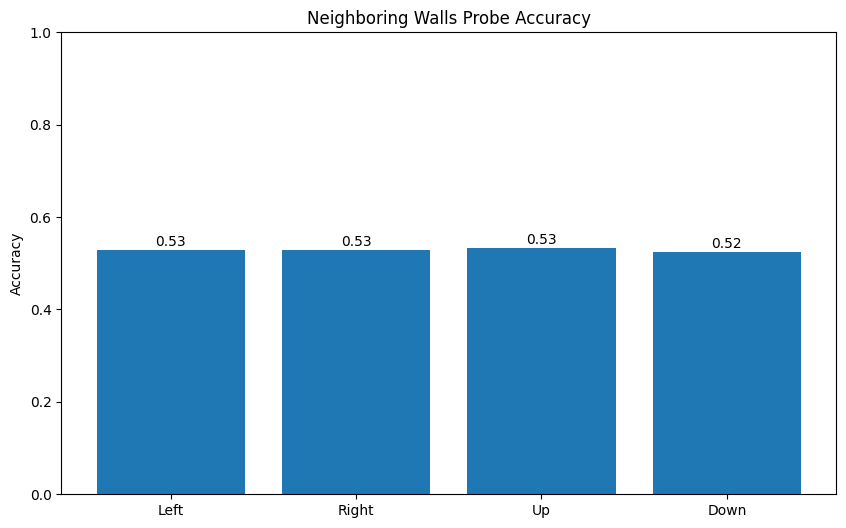

Original dataset size: 4000
Filtered dataset size: 3182
Removed 818 observations with fewer than 5 actions


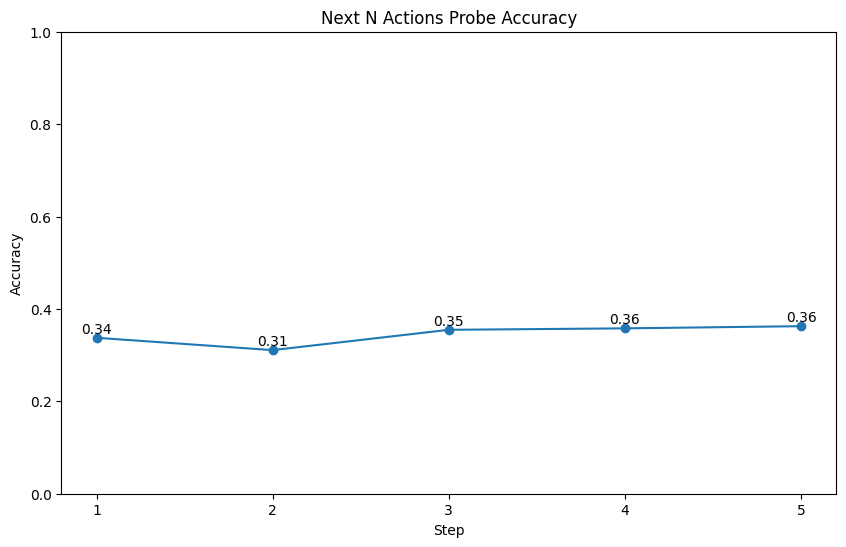

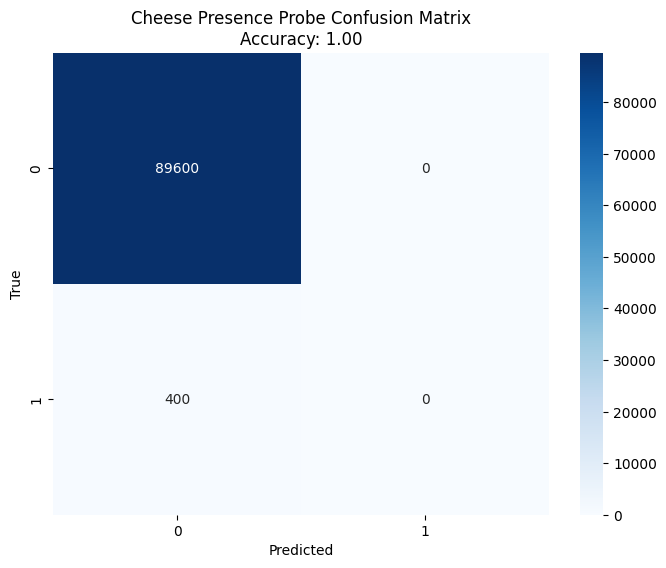

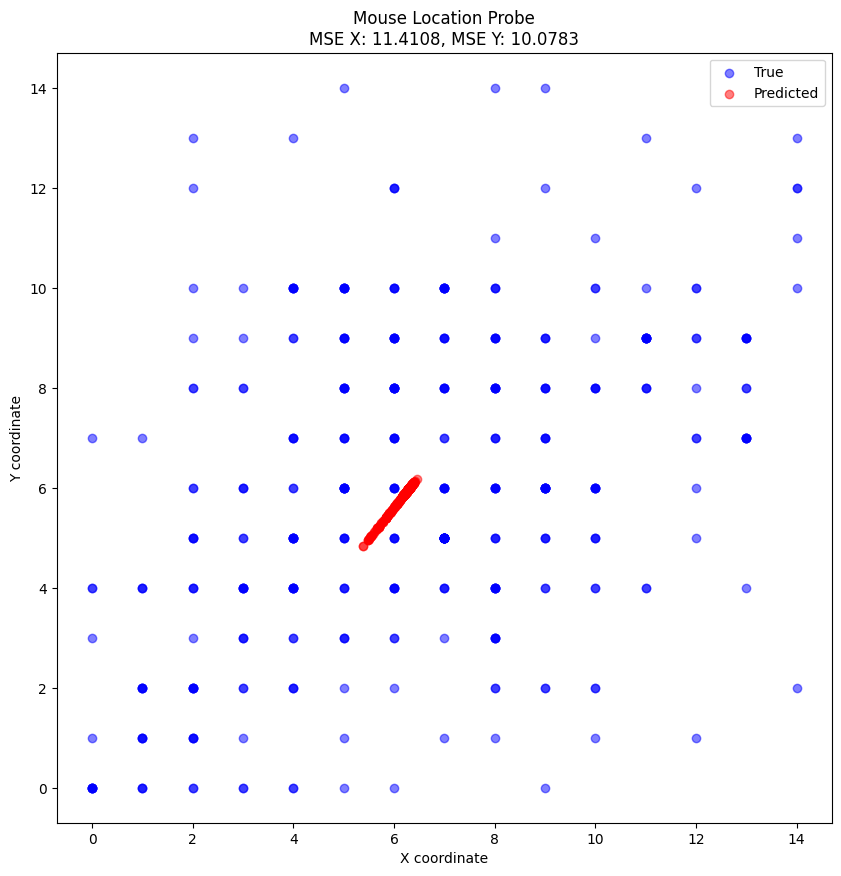

In [21]:
probes = torch.load("trained_probes_20000.pt")
from src.probing import *
for layer, layer_probes in probes.items():
    print(f"Visualizing results for layer: {layer}")
    visualize_neighboring_walls_probe(layer_probes['neighboring_walls'], test_data)
    visualize_next_n_actions_probe(layer_probes['next_n_actions'], test_data)
    visualize_cheese_presence_probe(layer_probes['cheese_presence'], test_data)
    visualize_mouse_location_probe(layer_probes['mouse_location'], test_data)